# A COMMUNICATION CRISIS ?
# Inequalities in media representation through quotes 


## Table of Contents

* [Introduction](#chapter1)
* [Dataset Exploration](#chapter2)
    * [WikiDataset](#section_2_1)
    * [QuoteBank dataset](#section_2_2)
    * [BBC dataset](#section_2_3)
* [Machine Learning methods training to categorize quotations](#chapter3)
    * [label encoding](#section_3_1)
    * [Splitting into train and test sets](#section_3_2)
    * [Building the models](#section_3_3)
        * [Random Forest ](#section_3_3_1)
        * [Logictic Regression ](#section_3_3_2)
        * [K-Nearest Neighbours](#section_3_3_3)
        * [Naive Bayes Classifier](#section_3_3_4)
    * [Conclusion](#section_3_5)
* [Generation of labels for QuoteBank Dataset](#chapter4)
    * [Application of the logistic regression model](#section_4_1)
    * [Proportion of topics](#section_4_2)
    * [Time evolution of topics](#section_4_3)
    * [Conclusion for further analysis](#section_4_4)
* [Categorization of the speakers](#chapter5)
    * [Age Analysis](#section_5_1)
        * [Overall Age distribution](#section_5_1_1)
        * [Age distribution per topics](#section_5_1_2)
        * [Time evolution of mean age of speakers](#section_5_1_3)
    * [Gender analysis](#section_5_2)
        * [Gender distribution per topic](#section_5_2_1)
        * [Time evolution of gender representation](#section_5_2_2)
    * [Representation of age and gender across news sources](#section_5_3)
    * [Nationality analysis](#section_5_4)
        * [Overall nationality distribution](#section_5_4_1)
        * [Nationality distribution per topics](#section_5_4_2)
        * [Evolution of nationality representation over time](#section_5_4_3)
        * [Link between nationality and and date of birth representation](#section_5_4_4)
        * [Link between nationality and gender representation](#section_5_4_5)
* [Final conclusion](#chapter6)

## Introduction <a class="anchor" id="chapter1"></a>

The main goal of our project is to find what characteristics the different news sources look for in speakers, depending on the subject of discussion. To answer this question, we are going to work with three different datasets. Indeed, we will base our analyse on The Quotebank dataset that contains quotes of speakers from 2015 to 2020. The BBC dataset will help us to train a method to regroup the quotes according to the main topics. Finally, using the Wikidataset, we aim to categorize the speakers thanks to their age, gender and nationality. 
With all those informations, we will be able to perform a number of analysis to study the evolution across different news sources of the most represented speaker in the press.

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from tqdm import tqdm
import bz2
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

## Dataset Exploration <a class="anchor" id="chapter2"></a>

A primary work consists of performing initial analyses and cleaning of the three datasets.

### WikiDataset <a class="anchor" id="section_2_1"></a>
The Wikidataset will be used to find the age, gender and nationality of the speakers.


The first aim is to explore the content of this dataset. We remove all the missing values, and we keep only the columns that we are interested in, that is : date of birth, nationality, gender and Id number of the speaker.

In [2]:
# Access to wikipedia data from broswer: https://www.wikidata.org/wiki/QXXX
pq = pd.read_parquet("speaker_attributes.parquet/part-00000-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet")
pq.head(2)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None


In [3]:
#helper function that removes all lines with NaN value
def remove_nan(df): 
    mask = df.isnull()
    mask = mask.any(axis=1)
    nb_nan = mask.sum()
    return df[~mask.values].reset_index(drop=True), nb_nan


path = "speaker_attributes.json.bz2" #path where save the metadata
nb = ['0000','0001','0002','0003','0004','0005','0006','0007','0008',
      '0009','0010','0011','0012','0013','0014','0015']

#Choose which column we keep from parquet 
col = ['date_of_birth', 'nationality', 'gender','id']
TOT_nb_nan = 0
TOT_size = 0
with bz2.open(path, 'wb') as file:
    for i in tqdm.tqdm(range(len(nb))):
        parquet = pd.read_parquet("speaker_attributes.parquet/part-0"+nb[i]+"-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet")
        TOT_size += parquet.shape[0]
        parquet_buff = parquet[col].copy()
        parquet_buff,nb_nan = remove_nan(parquet_buff)
        TOT_nb_nan += nb_nan
        file.write(parquet_buff.to_json(compression='bz2',lines=True, orient='records').encode('utf-8'))

print(f'We remove {TOT_nb_nan} over a total of {TOT_size}.')

100%|██████████| 16/16 [01:14<00:00,  4.69s/it]

We remove 6011526 over a total of 9055981.


In [4]:
#Display filtered Wikidataset 
parquet = pd.read_json('speaker_attributes.json.bz2',lines=True, orient='records', compression='bz2') 
print(f'Shape of filtered parquets:{parquet.shape}')
parquet.head(2)

Shape of filtered parquets:(3044455, 4)


,date_of_birth,nationality,gender,id
0,[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],Q23
1,[+1952-03-11T00:00:00Z],[Q145],[Q6581097],Q42


To find the age of the speaker, we make the decision to clean the data by keeping only the year of birth. Moreover, some speakers happen to have more than one attribute. In that case, we choose  to keep only one attribute per column.

In [5]:
pq_buffer = parquet.copy()
#if there are more than one value in a fild we make the arbitrary decision to choose only one
pq_buffer['nationality'] = pq_buffer['nationality'].apply(lambda x: x[0])
pq_buffer['gender'] = pq_buffer['gender'].apply(lambda x: x[0])

pq_buffer['date_of_birth'] = pq_buffer['date_of_birth'].apply(lambda x: x[0][1:5]) #save only year 
pq_buffer.head(2)

,date_of_birth,nationality,gender,id
0,1732,Q161885,Q6581097,Q23
1,1952,Q145,Q6581097,Q42


Each gender and nationality is characterized by a QID number. We process our dataset to associate the QID number to the written value it corresponds to. To do so, we use the the Wikidata labels description quote bank file that links every nationality and gender QID number.

In [6]:
#load data for label description 
label =  pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2') 
label.head(2)

,QID,Label,Description
0,Q31,Belgium,country in western Europe
1,Q45,Portugal,country in southwestern Europe


In [7]:
#Generate dict for replace qids with label
mask1 = label['QID'].isin(set(pq_buffer.nationality))
dict_nat = dict(zip(label.QID[mask1],label.Label[mask1]))
mask2 = label['QID'].isin(set(pq_buffer.gender))
dict_gen = dict(zip(label.QID[mask2],label.Label[mask2]))

#replace qid
pq_buffer = pq_buffer.replace(dict_nat)
pq_buffer = pq_buffer.replace(dict_gen)
pq_buffer.head(2)

,date_of_birth,nationality,gender,id
0,1732,Great Britain,male,Q23
1,1952,United Kingdom,male,Q42


In [8]:
#save the clean and processed wikidataset 
path = "speaker_attributes_final.json.bz2"
with bz2.open("speaker_attributes_final.json.bz2", 'wb') as d_file:
    d_file.write(pq_buffer.to_json(compression='bz2',lines=True, orient='records').encode('utf-8'))

Each speaker’s gender, age and nationality can now be found according to their Id number. We can proceed to work on the Quotebank dataset.

### QuoteBank Dataset <a class="anchor" id="section_2_2"></a>

We will load and process the Quotebank dataset. This dataset contains quotes from different speakers from different news sources  (for each year from 2015 to 2020).

The Quotebank dataset is filtered by dropping all the lines containing missing values with respect to the speaker. As we will analyze our datas across different news sources, we convert the urls in site names. In order to be able to generate plots for further analysis, we choose to round the date of the quotes. Indeed, our analysis will be based on big timescale (day or years), so we remove the minutes and seconds. We use the WikiData  previously cleaned and processed to avoid mistakes in futur analyses : we drop all the quotes that are not surely associated with a speaker, as well as the lines containing speakers that do not match with a Wikidata Id. 

We also choose to get rid of unnecessary characters and stop words in the quotations. The purpose of this cleaning is to be able to perform easier word analysis when applying our Machine Learning method to generate groups of quotes by main topics.

In [9]:
#load speaker_attributes
path = "speaker_attributes_final.json.bz2"
speaker_atr = pd.read_json(path, lines=True, compression='bz2')

In [18]:
#helper function to clean the quote
def process_text(text):
    #removing some characters
    text = text.lower().replace('\n',' ').replace('\r','').strip()
    text = re.sub(' +', ' ', text)
    text = re.sub(r'[^\w\s]','',text)
    
    #removing stopwords that will not contribute to the classification
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(text) 

    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
    
    text = " ".join(filtered_sentence)
    return text

'''
Helper function that clean a chunck dataframe and save only the data
of interest: 'quotation', 'speaker', 'qids', 'date', 'urls' -> 'site'.
'''
def clean_chunk(chunk):        
        #Check and remove the NaN value 
        chunk.replace('None', np.nan, inplace=True) # We need to convert the string None to a proper one.
        chunk, nb_nan = remove_nan(chunk)
                
        #convert the urls in site
        chunk['urls'] = [line[0].split('/')[2].replace('www.','') for line in chunk['urls']]
        
        #we round the timestamp to day
        chunk['date'] = chunk['date'].round('D')
        
        #drop the line where we are not sure who is the speaker (multiple pepole with the same name)
        nb_mult_name = chunk.shape[0] 
        len_quis = chunk.qids.apply(len)
        chunk = chunk[len_quis == 1]
        nb_mult_name = nb_mult_name - chunk.shape[0] #how many element we drop
        chunk['qids'] = chunk['qids'].apply(lambda x: x[0])
        
        #drop the line where the speaker doesn't have a wikidata
        nb_nonmatch = chunk.shape[0]
        chunk = chunk[chunk.qids.isin(speaker_atr.id)]
        nb_nonmatch = nb_nonmatch - chunk.shape[0] #how many element we drop
        
        #covert the quotation in proper one 
        chunk['quotation'] = chunk['quotation'].apply(process_text)
        chunk = chunk[chunk['quotation'].apply(len) > 1]
        
        return chunk.reset_index(drop=True), nb_nan, nb_mult_name, nb_nonmatch



We perform all the steps mentioned above on the Quotebank datasets from the years of 2015 to 2020. In order to visualize our filtered data we save the quotation length, the dates and the urls in a counter.

In [11]:
'''
Helper function to filter and save the dataset of a certain year, 
it returns the counters for visualisation and statitical analysis 
'''
def clean_dataset(path_dataset, path_dataset_clean):
    #Choose which column from dataset save
    col = ['quotation','speaker','date','qids', 'urls']  
    TOT_nb_nan = 0
    TOT_nb_mult_name = 0
    TOT_nb_nonmatch = 0
    TOT_size = 0
    TOT_size_clean = 0
    counter_quote, counter_date, counter_urls = Counter(),Counter(),Counter()
    with pd.read_json(path_dataset, lines=True, compression='bz2', chunksize=100000) as df_reader:
        with bz2.open(path_dataset_clean, 'wb') as d_file:
            count = 0
            for chunk in df_reader:
                print(f'({count}) Processing chunk with {chunk.shape[0]} rows', end='\r')
                TOT_size += chunk.shape[0]
                df, nb_nan, nb_mult_name, nb_nonmatch = clean_chunk(chunk[col].copy()) #remove odd values
                
                #count number odd value
                TOT_nb_nan += nb_nan
                TOT_nb_mult_name += nb_mult_name
                TOT_nb_nonmatch += nb_nonmatch
                TOT_size_clean += df.shape[0]

                #Store data for visualisation 
                counter_quote += Counter(df['quotation'].apply(len))
                counter_date += Counter(df['date'])
                counter_urls += Counter(df['urls'])
                
                #write in the ouput file
                d_file.write(df.to_json(compression='bz2',lines=True, orient='records').encode('utf-8'))
                count+=1
                
    print(f'We remove {TOT_nb_nan+ TOT_nb_mult_name + TOT_nb_nonmatch} over a total of {TOT_size}')
    print(f'No speaker {(TOT_nb_nan/TOT_size)*100} %')
    print(f'Speaker with multiple possible name {(TOT_nb_mult_name/TOT_size)*100} %')
    print(f'Speaker that do not mach the metadata {(TOT_nb_nonmatch/TOT_size)*100} %')
    print(f'The final shape of the dataset is {TOT_size_clean}')
    return counter_quote, counter_date, counter_urls



We define some helper functions to help plot the data and calculate statistic. In particular they plot the distribution for the quotes and  dates. They also print the most frequent url, and calculate min, max and mean for the quote lenght.

In [12]:
#helper function for quote: print the mean, min and max and plot the dstribution.
def describe_len_quote(counter_quote):
    quote = pd.DataFrame.from_records(counter_quote.most_common(), columns=['value','count'])
    mean = ((quote['value']*quote['count']).sum())/quote['count'].sum()
    max_ = quote['value'].max()
    min_ = quote['value'].min()
    print(f'Quote length: mean = {mean}, max = {max_}, min = {min_}')
    plt.figure(figsize=(16, 5))
    plt.bar(quote['value'], quote['count'], edgecolor="k")
    plt.title('Distribution Length Quote',fontsize=15)
    plt.show()
    
#helper function for date: plot the dstribution.  
def describe_date(counter_date):
    date = pd.DataFrame.from_records(counter_date.most_common(), columns=['value','count'])
    plt.figure(figsize=(16, 5))
    plt.bar(date['value'], date['count'], edgecolor="k")
    plt.title('Distribution Date',fontsize=15)
    plt.xticks(rotation=45)
    plt.show()
    
#helper function for urls, print most frequent
def describe_urls(counter_urls):
    urls = pd.DataFrame.from_records(counter_urls.most_common(), columns=['value','count'])
    max_ = urls['count'].max()
    val = urls['value'][urls['count'] == max_].item()
    print(f'The most frequent urls is {val} and it is present {max_} time.')
    print(f'The next 5 most frequent urls are: \n {urls[1:6]}')
    

##### Year 2020 Dataset claning and analysis 

In [13]:
#Path to dataset and the new dataset
path_dataset = 'quotes-2020.json.bz2' 
path_dataset_clean = 'quotes-2020-clean.json.bz2'
counter_quote, counter_date, counter_urls  = clean_dataset(path_dataset, path_dataset_clean)

We remove 3125918 over a total of 5244449
No speaker 34.338097291059555 %
Speaker with multiple possible name 17.765450669841577 %
Speaker that do not mach the metadata 7.500768908230397 %
The final shape of the dataset is2118203


Quote length: mean = 86.02659188000395, max = 2472, min = 2


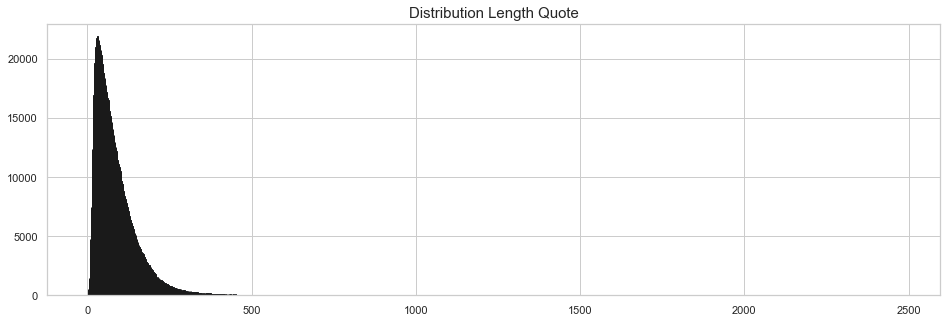

In [14]:
describe_len_quote(counter_quote)

The mean length of the quotes is quite short : around 86 characters, this result shows that the method for categorizing the quotes into groups of topics should work in an efficient way on our filtered QuoteBank dataset. 

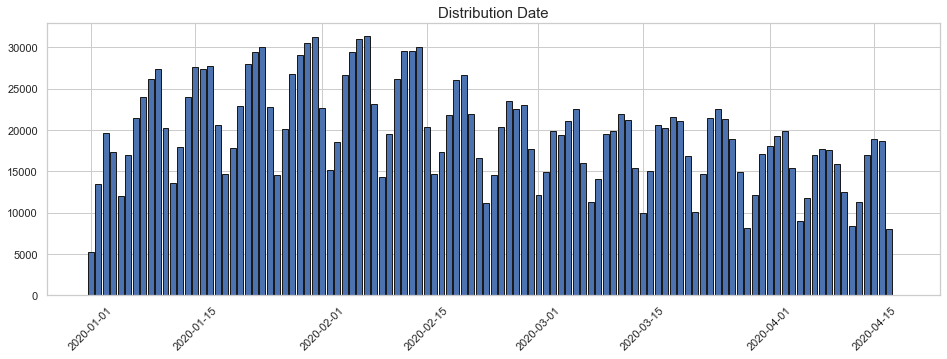

In [15]:
describe_date(counter_date)

We can assume that our dataset is well distributed over the time based on the 2020 dataset. Therefore, we will indeed be able to perform analysis over time in our futur work. On looking regulary spikes that we see we can deduct that represent the week day/weekend day.

In [16]:
describe_urls(counter_urls)

The most frequent urls is msn.com and it is present 28521 time.
The next 5 most frequent urls are: 
               value  count
1     breitbart.com  25786
2     express.co.uk  13747
3       foxnews.com  12734
4  seattletimes.com  11918
5     nbcsports.com  11889


We than perform the same analysis and cleaning for the datasets from other years.

##### Year 2019 Dataset cleaning and analysis 

In [17]:
path_dataset = 'quotes-2019.json.bz2' 
path_dataset_clean = 'quotes-2019-clean.json.bz2'
counter_quote, counter_date, counter_urls  = clean_dataset(path_dataset, path_dataset_clean)

We remove 13108699 over a total of 21763302
No speaker 34.82931036843582 %
Speaker with multiple possible name 17.96644645192168 %
Speaker that do not mach the metadata 7.437285941260201 %
The final shape of the dataset is8653437


Quote length: mean = 86.43332597209641, max = 2550, min = 2


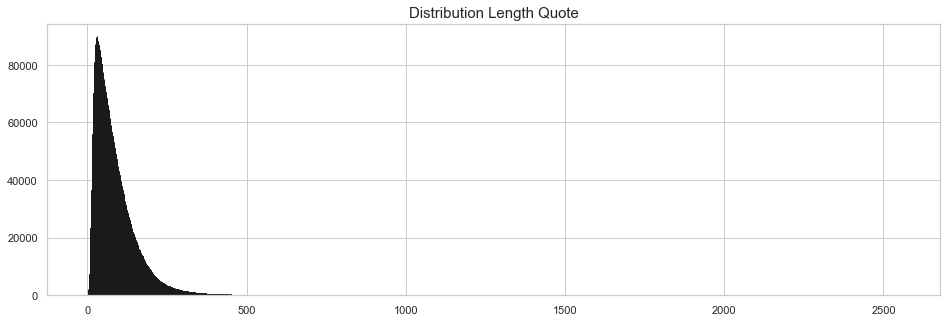

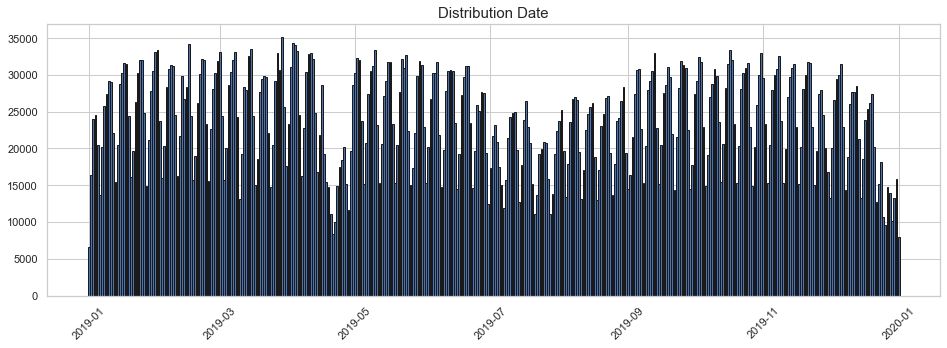

The most frequent urls is breitbart.com and it is present 106909 time.
The next 5 most frequent urls are: 
               value  count
1           msn.com  93493
2       nytimes.com  65791
3  seattletimes.com  59026
4     express.co.uk  50881
5     nbcsports.com  48038


In [18]:
describe_len_quote(counter_quote)
describe_date(counter_date)
describe_urls(counter_urls)

##### Year 2018 Dataset cleaning and analysis 

In [19]:
path_dataset = 'quotes-2018.json.bz2' 
path_dataset_clean = 'quotes-2018-clean.json.bz2'
counter_quote, counter_date, counter_urls  = clean_dataset(path_dataset, path_dataset_clean)

We remove 16650155 over a total of 27228451
No speaker 35.10310593871095 %
Speaker with multiple possible name 18.45661730812377 %
Speaker that do not mach the metadata 7.590119614222638 %
The final shape of the dataset is10576739


Quote length: mean = 84.79311127938394, max = 2636, min = 2


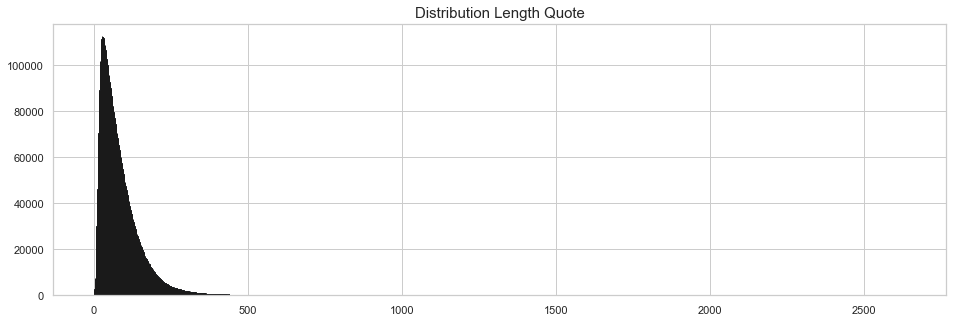

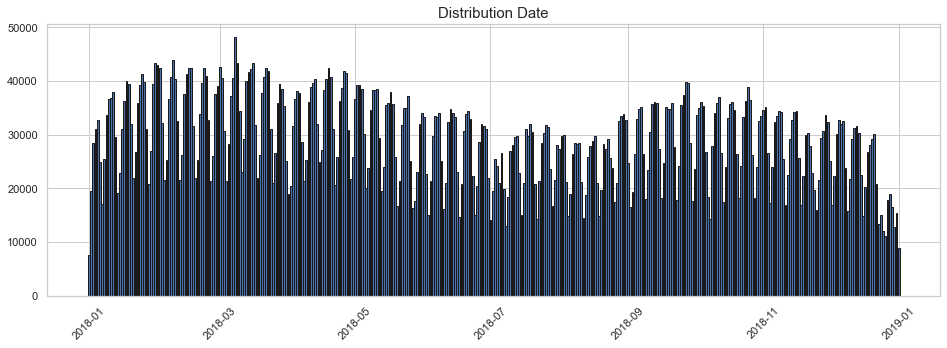

The most frequent urls is breitbart.com and it is present 82235 time.
The next 5 most frequent urls are: 
                  value  count
1              msn.com  79214
2          nytimes.com  68708
3    home.nzcity.co.nz  51460
4  washingtontimes.com  43251
5          mlb.mlb.com  40251


In [20]:
describe_len_quote(counter_quote)
describe_date(counter_date)
describe_urls(counter_urls)

##### Year 2017 Dataset cleaning and analysis 

In [21]:
path_dataset = 'quotes-2017.json.bz2' 
path_dataset_clean = 'quotes-2017-clean.json.bz2'
counter_quote, counter_date, counter_urls  = clean_dataset(path_dataset, path_dataset_clean)

We remove 16401377 over a total of 26611588
No speaker 34.86560065487261 %
Speaker with multiple possible name 19.22312565488388 %
Speaker that do not mach the metadata 7.543736209954852 %
The final shape of the dataset is10208628


Quote length: mean = 83.19875726689229, max = 2344, min = 2


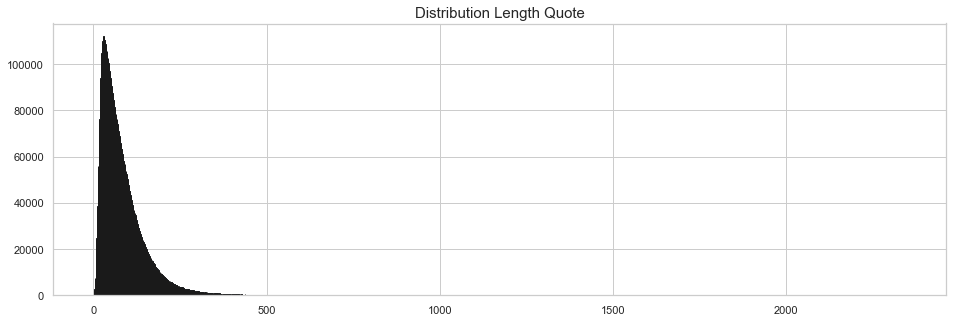

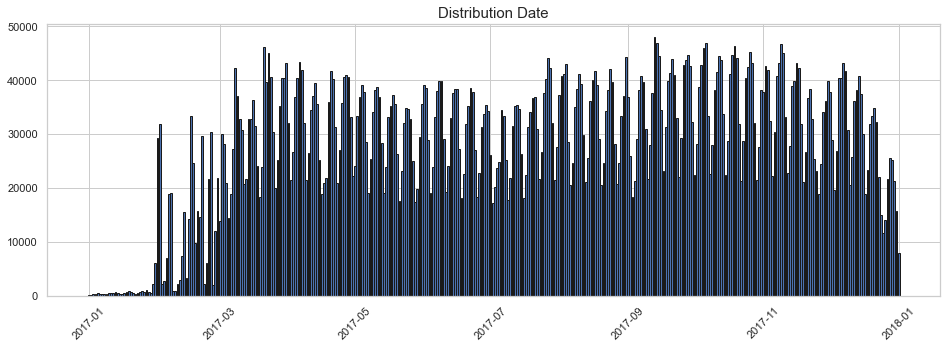

The most frequent urls is washingtonpost.com and it is present 83850 time.
The next 5 most frequent urls are: 
                value  count
1            msn.com  74646
2        nytimes.com  71355
3        mlb.mlb.com  44746
4  home.nzcity.co.nz  41730
5      breitbart.com  39773


In [22]:
describe_len_quote(counter_quote)
describe_date(counter_date)
describe_urls(counter_urls)

##### Year 2016 Dataset cleaning and analysis 

In [23]:
path_dataset = 'quotes-2016.json.bz2' 
path_dataset_clean = 'quotes-2016-clean.json.bz2'
counter_quote, counter_date, counter_urls  = clean_dataset(path_dataset, path_dataset_clean)

We remove 8512408 over a total of 13862129
No speaker 34.30508401703663 %
Speaker with multiple possible name 19.75080451206305 %
Speaker that do not mach the metadata 7.351763931788543 %
The final shape of the dataset is5348900


Quote length: mean = 81.6115160126381, max = 2231, min = 2


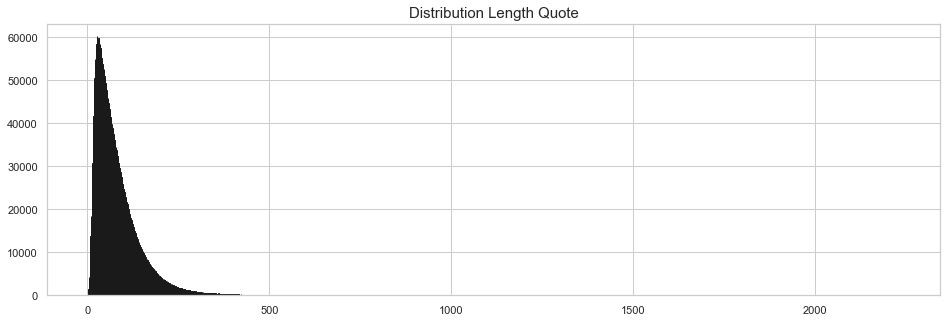

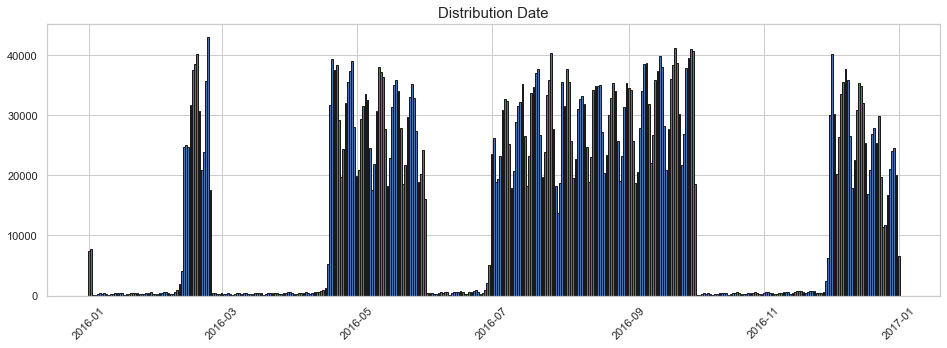

The most frequent urls is washingtonpost.com and it is present 37580 time.
The next 5 most frequent urls are: 
                 value  count
1         mlb.mlb.com  33261
2         espn.go.com  31771
3         nytimes.com  30554
4  huffingtonpost.com  28218
5             msn.com  27118


In [24]:
describe_len_quote(counter_quote)
describe_date(counter_date)
describe_urls(counter_urls)

##### Year 2015 Dataset cleaning and analysis 

In [25]:
path_dataset = 'quotes-2015.json.bz2' 
path_dataset_clean = 'quotes-2015-clean.json.bz2'
counter_quote, counter_date, counter_urls  = clean_dataset(path_dataset, path_dataset_clean)

We remove 12637271 over a total of 20874338
No speaker 33.612083889798086 %
Speaker with multiple possible name 19.807224545276597 %
Speaker that do not mach the metadata 7.120436585821309 %
The final shape of the dataset is8235740


Quote length: mean = 81.57253118724, max = 4247, min = 2


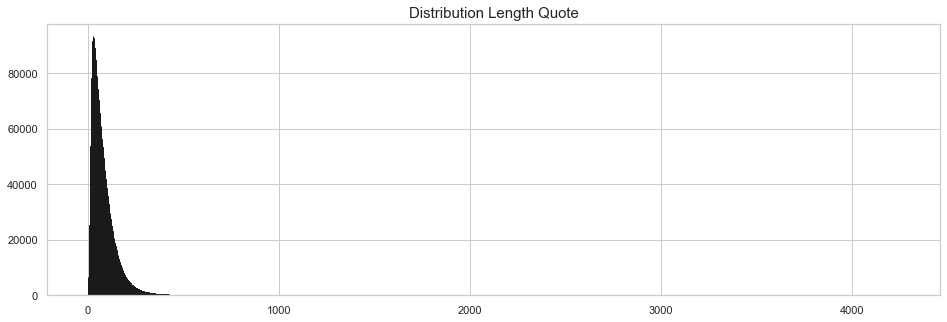

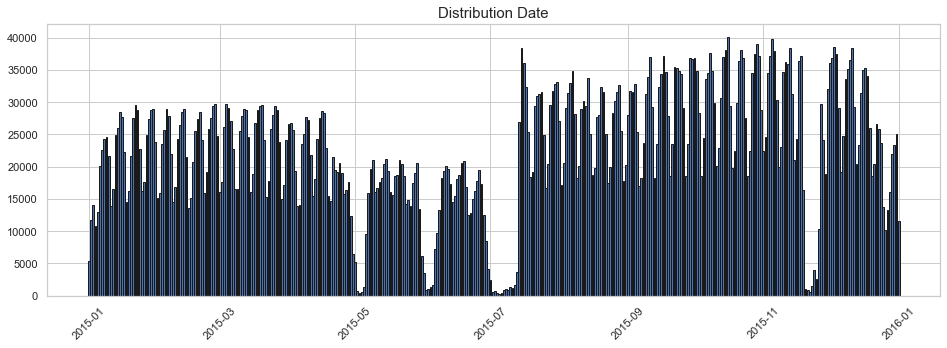

The most frequent urls is feeds.theguardian.com and it is present 95417 time.
The next 5 most frequent urls are: 
                       value  count
1               mlb.mlb.com  73094
2  feeds.washingtonpost.com  51170
3               espn.go.com  50457
4                philly.com  44191
5         au.news.yahoo.com  41525


In [26]:
describe_len_quote(counter_quote)
describe_date(counter_date)
describe_urls(counter_urls)

From the above distribution of date, we can notice that some datasets are well distributed over time (2020, 2019, 2018 and 2017) but the dataset from the years 2016 and 2015 show irregular distribution of the dates. Therefore, we will be able to perform analysis over the years without any issue. However, if we would like to analyze our data over the months, we will need to take into account the fact that some month from 2015 and 2016 has a much smaller set of quotations when we will make the deduction and interpretation of our result. 

Moreover, the mean quote length from all the years is comparable (always around 81 to 86 characters). This allows us to deduct that the method for categorizing the quotes into groups of topics computed using the BBC Dataset should work in an efficient way on our filtered QuoteBank dataset for all the years.

### BBC Dataset <a class="anchor" id="section_2_3"></a>
In this part we will preprocess the additional dataset for our project of classification of newsquotes into categories.
We will make use of the BBC news articles dataset that can be seen below. It is a datat set that contains thousands of news articles classified into five categories: *Business*, *Entertainement*, *Sports*, *Tech*, *Politics*.

The goal is to train a machine learning model capable of reading a quote and assigning it to one of these five categories. For this we will first have a look at the BBC news articles dataset and clean it. In a subsequent step we will train and test our model on this same dataset. Finally the model will be used to classify the quotes of the quotebank dataset. 

In [3]:
#importing the train set
train = './BBC_data/BBC News Train.csv'
train_data = pd.read_csv(train)

In [4]:
train_data.head(2)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business


##### Let's look at the content
Here we will explore the content of the train data set: we will look at the present categories, the number of datapoints and we will check for missing values. 

In [5]:
#We have five distinct categories: business, tech, politics, sports, and entertainement 
train_data['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [6]:
#how many data points do we have ?
#we have 1490 data points and three columns: Article id, Text and the category that the article belongs to
train_data.shape

(1490, 3)

In [7]:
#Now we check if there are missing values
train_data.isnull().any()

ArticleId    False
Text         False
Category     False
dtype: bool

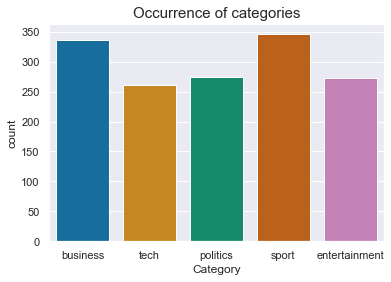

In [8]:
#Here we see how the data is balanced. We don't have a clear oversampling. 
sns.set_theme(style="darkgrid")
sns.set_palette("colorblind")
ax = sns.countplot(x="Category", data=train_data).set_title('Occurrence of categories', fontsize=15)

##### Dealing with word length
We know that this dataset contains news artices. Howvere, the quotebank dataset that we wish to classify contains quotes. The differene between the two is that news articles most likely are much longer than quotes. This means that we will probably have to truncate the news articles to match the average length of the quotes

In [19]:
#Let's look at the lentgh of the articles
train_data['Text'].str.len()

0       1866
1       2016
2       3104
3       3618
4       2190
        ... 
1485    1266
1486    3111
1487    1370
1488    3242
1489    1723
Name: Text, Length: 1490, dtype: int64

In [20]:
#we add a column to our train data set that contains the length of the quotes
train_data['len_of_article'] = train_data['Text'].str.len()
train_data['len_of_article']

0       1866
1       2016
2       3104
3       3618
4       2190
        ... 
1485    1266
1486    3111
1487    1370
1488    3242
1489    1723
Name: len_of_article, Length: 1490, dtype: int64

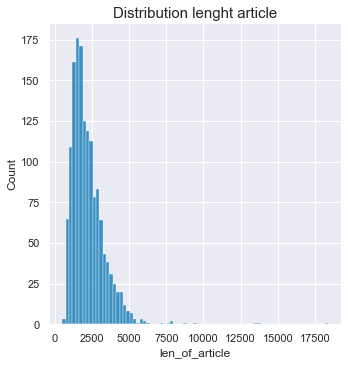

In [21]:
sns.set_theme(style="darkgrid")
sns.set_palette("colorblind")
sns.displot(data=train_data, x="len_of_article")
plt.title('Distribution lenght article', fontsize=15)
plt.show()

In [22]:
#let's print some summary statistics 
train_data['len_of_article'].describe()

count     1490.000000
mean      2233.461745
std       1205.153358
min        501.000000
25%       1453.000000
50%       1961.000000
75%       2751.250000
max      18387.000000
Name: len_of_article, dtype: float64

In [23]:
#and the median
train_data['len_of_article'].median()

1961.0

We can see in the notebook where we explored the Quotebank dataset, that these values are much higher than for the quotes we will ultimately classify. Therefore, it might be useful to truncate these articles before training our model on it. We will truncate these articles at 200 characters.


In [24]:
train_data['truncated']=train_data['Text'].str.slice(stop=200)
train_data['len_of_truncated_article'] = train_data['truncated'].str.len()


In [25]:
train_data.head(2)

,ArticleId,Text,Category,len_of_article,truncated,len_of_truncated_article
0,1833,worldcom ex-boss launches defence lawyers defe...,business,1866,worldcom ex-boss launches defence lawyers defe...,200
1,154,german business confidence slides german busin...,business,2016,german business confidence slides german busin...,200


##### Cleaning the data
Here we will do any cleaning of the data. We will remove unecessary characters and stopwords. We will only apply this cleaning to the truncated articles

In [26]:
train_data['clean_truncated'] = train_data['truncated'].apply(process_text)

In [27]:
train_data.head(2)

,ArticleId,Text,Category,len_of_article,truncated,len_of_truncated_article,clean_truncated
0,1833,worldcom ex-boss launches defence lawyers defe...,business,1866,worldcom ex-boss launches defence lawyers defe...,200,worldcom exboss launches defence lawyers defen...
1,154,german business confidence slides german busin...,business,2016,german business confidence slides german busin...,200,german business confidence slides german busin...


In [28]:
train_data.to_csv('./BBC_data/cleaned_Train.csv')

##### Preprocess the test set
The only thing we will do on the test set is to preprocess it in the same way as we did for the train dataset. That is, check for Nan values, truncate the articles and process the text in order to drop the useless charaters and words. 

In [29]:
#importing the test set
test = './BBC_data/BBC News Test.csv'
test_data = pd.read_csv(test)

In [30]:
test_data['truncated']=test_data['Text'].str.slice(stop=200)
test_data['len_of_truncated_article'] = test_data['truncated'].str.len()
test_data.head(2)

,ArticleId,Text,truncated,len_of_truncated_article
0,1018,qpr keeper day heads for preston queens park r...,qpr keeper day heads for preston queens park r...,200
1,1319,software watching while you work software that...,software watching while you work software that...,200


test_data['clean_truncated'] = test_data['truncated'].apply(process_text)

In [31]:
test_data.to_csv('./BBC_data/cleaned_Test.csv')

Next we will have to apply the same data cleaning and truncation to the Quotebank dataset. 
In a next step we will also try different machine learning models such as random forest, logistic regression, k neighbors classifier and naive bayes classifier. We will assess their quality by applying them on the test set and then we will chose the best and apply it to the quotebank dataset.

## Machine Learning methods training to categorize quotations <a class="anchor" id="chapter3"></a>

We have now all the information we need to execute our project in our three datasets : 
The BBC dataset is ready to be used to find a machine learning method (random forest, logistic regression, k neighbors classifier or naive bayes classifier) that gives the best performance to categories our news quotes into categories. This implies that we will first train four models and then test our models on a cleaned test set. 

In [32]:
#importing the train set
train = './BBC_data/cleaned_Train.csv'
train_data = pd.read_csv(train)

In [33]:
train_data.head(5)

,Unnamed: 0,ArticleId,Text,Category,len_of_article,truncated,len_of_truncated_article,clean_truncated
0,0,1833,worldcom ex-boss launches defence lawyers defe...,business,1866,worldcom ex-boss launches defence lawyers defe...,200,worldcom exboss launches defence lawyers defen...
1,1,154,german business confidence slides german busin...,business,2016,german business confidence slides german busin...,200,german business confidence slides german busin...
2,2,1101,bbc poll indicates economic gloom citizens in ...,business,3104,bbc poll indicates economic gloom citizens in ...,200,bbc poll indicates economic gloom citizens maj...
3,3,1976,lifestyle governs mobile choice faster bett...,tech,3618,lifestyle governs mobile choice faster bett...,200,lifestyle governs mobile choice faster better ...
4,4,917,enron bosses in $168m payout eighteen former e...,business,2190,enron bosses in $168m payout eighteen former e...,200,enron bosses 168m payout eighteen former enron...


### Label encoding <a class="anchor" id="section_3_1"></a>

As a preliminary step, we have to perform label encoding. This will transform our textual labels into numbers between 0 and number of classes - 1.

In [34]:
label_encoder = preprocessing.LabelEncoder()
train_data['category_target'] = label_encoder.fit_transform(train_data['Category'])

In [35]:
train_data.head(2)

,Unnamed: 0,ArticleId,Text,Category,len_of_article,truncated,len_of_truncated_article,clean_truncated,category_target
0,0,1833,worldcom ex-boss launches defence lawyers defe...,business,1866,worldcom ex-boss launches defence lawyers defe...,200,worldcom exboss launches defence lawyers defen...,0
1,1,154,german business confidence slides german busin...,business,2016,german business confidence slides german busin...,200,german business confidence slides german busin...,0


### Splitting into train and test sets <a class="anchor" id="section_3_2"></a>

In order to have a test set on which we can test our model, we need to sacrifice part of our data and assign it to a test set

In [50]:
#Here we form the features and targets for both train and test set. 
#We are assigning 80% of the data to the train set, and 20% to the test set
X_train, X_test, y_train, y_test = train_test_split(train_data['clean_truncated'], 
                                                    train_data['category_target'], 
                                                    test_size=0.1, 
                                                    random_state=8)

Now we need to perform text vectorization. That is, transform the text into a ector of numbers. We need to do this because we will then have to train our model on numerical features rather than text. 

Concretely we apply the method TfidfVectorizer which transforms each quote into a vector of numbers which represent for each word, the frequency of appearance in the sentence and in the whole dataset.

In [51]:
#Now we need to convert the text in vectorial form 
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 200

In [52]:
TFIDF = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = TFIDF.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = TFIDF.transform(X_test).toarray()
labels_test = y_test

(1341, 200)


### Building the models <a class="anchor" id="section_3_3"></a>

Here we will train four models only with the train dataset. We will then directly assess the model by computing the accuracy on the test dataset.

#### Random Forest <a class="anchor" id="section_3_3_1"></a>

The idea behind random forest is to train a series of decision trees with the possibility to bootstrap the dataset. Another feature of random forest is that at each split in each decision tree, the model is only allowed to use part of the predictors. This allows to decorrelate the different trees that are built. When using the random forest to classify data points, we look at the class that is predicted by most decision trees.

We will again use the random forest method sklearn.

In [53]:
#declare and fit the model
model  = RandomForestClassifier(random_state=1)
model.fit(features_train, labels_train)

#make predictions on the testset
model_predictions = model.predict(features_test)

#print accuracy and other indicative values
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.825503355704698
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        37
           1       0.93      0.81      0.87        32
           2       0.91      0.75      0.82        28
           3       0.89      0.94      0.91        34
           4       0.54      0.72      0.62        18

    accuracy                           0.83       149
   macro avg       0.82      0.81      0.81       149
weighted avg       0.84      0.83      0.83       149



In [54]:
#These are the default parameters of random forest
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

As we see, random forest gives an accuracy of 0.8255. Now we can try to increase the accuracy by tuning some of the hyperparameters.

We will tune four hyperparameters: the number of trees to build in each model, the maximal depth, the minimum number of samples needed for a split, and the minimum number of samples in a leaf. To do this we will define several possible values for each of these parameters and then build one model for each possible combination of the values.

In [55]:
#Define a four hyperparameters to tune
n_estimators = [50, 100, 150, 200]
max_depth = [25, 30, 35]
min_samples_split = [3, 4, 5, 6, 7]
min_samples_leaf = [1, 2, 3, 4] 

#define a dict with the different hyperparameters
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

#perform grid search with 3-fold cross validation
gridF = GridSearchCV(model, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(features_train, labels_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


In [56]:
#These are the best values according to the 3-fold cross validation
bestF.best_params_

{'max_depth': 35,
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 200}

In [66]:
#Train the model again but with tuned hyperparameters. 
model1  = RandomForestClassifier(random_state=1,max_depth= 35, min_samples_leaf= 1, min_samples_split= 7, n_estimators= 200)
model1.fit(features_train, labels_train)

#Test the model on the test set
model_predictions = model1.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.8187919463087249
              precision    recall  f1-score   support

           0       0.85      0.78      0.82        37
           1       0.96      0.84      0.90        32
           2       0.88      0.75      0.81        28
           3       0.73      0.97      0.84        34
           4       0.67      0.67      0.67        18

    accuracy                           0.82       149
   macro avg       0.82      0.80      0.81       149
weighted avg       0.83      0.82      0.82       149



We see that the accuracy do not improve.

#### Logistic Regression <a class="anchor" id="section_3_3_2"></a>

In this technique, instead of modeling the response directly, we model the probability that the output falls under a certain category. Based on this probability, we then assign each element to a category. 

$\begin{split}
P(t=1| z) & = \sigma(z) = \frac{1}{1+e^{-z}} \\
P(t=0| z) & = 1 - \sigma(z) = \frac{e^{-z}}{1+e^{-z}} 
\end{split}$

where $z = \sum_{i=0}^{p}\beta_i x_i$ and $x_i$ are the predictors and the $\beta_i$ are the parameters to be estimated.

Even though the logistic regression technique is usually used for binary classification, we can adapt it to multiclass classification. We will make use of the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">sklearn method</a> for logistic regression. In this method, we can use the one-vs-rest method to overcome the fact that we have multiple classes. This splits a multi-class classification into one binary classification problem per class. 

The loss function used for this method is the maximum likelihood estimator. This allows us to find the parameters $\beta_i$:

$\underset{\theta}{\text{argmax}}\; \mathcal{L}(\theta|t,z) = \underset{\theta}{\text{argmax}} \prod_{i=1}^{n} \mathcal{L}(\theta|t_i,z_i)$. where $\mathcal{L}(\theta|t,z) = P(t|z,\theta) = \prod_{i=1}^{n} P(t_i|z_i,\theta)$

 Again we will assess the accuracy by applying this model to the test set.

In [58]:
#Define and fit the model using the train sataset
model = LogisticRegression()
model.fit(features_train, labels_train)

#test the model
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.825503355704698
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        37
           1       0.96      0.84      0.90        32
           2       0.95      0.71      0.82        28
           3       0.91      0.88      0.90        34
           4       0.50      0.78      0.61        18

    accuracy                           0.83       149
   macro avg       0.83      0.82      0.81       149
weighted avg       0.86      0.83      0.83       149



We see that the accuracy of this model is 0.8255. We can again tune one hyperparameter, the inverse of the regularization strength.

In [59]:
#Here we define the values to try for the hypermarameter
param_grid = {'C': [0.1,0.001,1]}

#perform grid search with 3-fold cross validation
clf = GridSearchCV(model, param_grid, cv = 3, verbose = 1)

bestF = clf.fit(features_train, labels_train)
bestF.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


{'C': 1}

Here we see that the optimal C is 1, which is the default value. Therefore our model does not change

#### K-Nearest Neighbours <a class="anchor" id="section_3_3_3"></a>

This is a non-parametric classification method. The input to the algorithm consists of the $k$ closest training points in a data set. In $k$-NN classification, the output is a class membership, which defined by a plurality vote of its neighbors, with the object being assigned to the class most common among its $k$ nearest neighbors.

The description of this machine learning model was taken from <a href="https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm">Wikipedia</a>.

To implement this technique, we will use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html">sklearn method</a> for $k$-NN classifier.

To perform $k$-NN for text classification, we should find the closest data points for a given one and have a measure of distance. For this purpose we could use Jaccard similarity metric or cosine metric.

<a href="https://en.wikipedia.org/wiki/Jaccard_index#Probability_Jaccard_similarity_and_distance">Jaccard similarity metric</a>, which measures similarity between finite sample sets $A$ and $B$, is defined as the size of the intersection divided by the size of the union of the sample sets: $J(A,B)=\frac{|A \cap B|}{|A \cup B|}$.

<a href="https://en.wikipedia.org/wiki/Cosine_similarity">Cosine similarity metric</a> is a measure of similarity between two non-zero vectors of an inner product space. It is defined to equal the cosine of the angle between them. For two vectors $A$ and $B$ the cosine similarity can be written as $S_c(A,B)=cos(\theta)=\frac{A\cdot B}{\|A\|\cdot \|B\|}$.




Again we will test the model on the test set.

In [60]:
#Define and fit the model using the train dataset
model = KNeighborsClassifier()
model.fit(features_train, labels_train)

#test the model
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.6778523489932886
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        37
           1       0.62      0.78      0.69        32
           2       0.77      0.61      0.68        28
           3       0.71      0.71      0.71        34
           4       0.62      0.56      0.59        18

    accuracy                           0.68       149
   macro avg       0.68      0.67      0.67       149
weighted avg       0.68      0.68      0.68       149



In [61]:
#These are the parameters of the default KNN model
model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

The accuracy of the KNN model is of 0.68. For this model we can again tune two parameters, the number of nearest neighbors and the Power parameter for the Minkowski metric.

In [62]:
#Here we define the values to try for the hyperparameters
params_KNN = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7], 
              'p': [1, 2, 3, 4, 5]}

#perform grid search with 3-fold cross validation
gridF = GridSearchCV(model, params_KNN, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(features_train, labels_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


In [63]:
#Print the resulting values for the hyperparameters
bestF.best_params_

{'n_neighbors': 1, 'p': 4}

In [64]:
#Perform again fitting and testing of the model with tuned hyperparameters
model = KNeighborsClassifier(n_neighbors=5,p=1)
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.6040268456375839
              precision    recall  f1-score   support

           0       0.53      0.46      0.49        37
           1       0.58      0.69      0.63        32
           2       0.89      0.57      0.70        28
           3       0.60      0.71      0.65        34
           4       0.52      0.61      0.56        18

    accuracy                           0.60       149
   macro avg       0.62      0.61      0.61       149
weighted avg       0.62      0.60      0.60       149



With the tuned hyperparameters we get an accuracy of 0.60, which is worse.

#### Naive Bayes Classifier <a class="anchor" id="section_3_3_4"></a>

This is a classification algorithm based on Bayes’ Theorem with an assumption of independence between the features.

Naive Bayes is a conditional probability model: given a problem instance to be classified, represented by a vector $x = (x_1,…,x_n)$ representing some $n$ features (independent variables), it assigns to this input probabilities
$p(C_k|x_1,...,x_n)$ for each of $K$ possible classes $C_k$.

Using Bayes' theorem, we can write the conditional probability as $p(C_k|x)=\frac{p(C_k)p(x|C_k)}{p(x)}$.

Since the denominator is constant given the input and the numerator is equivalent to the joint probability model $p(C_k,x_1,...,x_n)$, we can rewrite it using the chain rule: $p(C_k,x_1,...,x_n)=p(x_1|x_2,...,x_n,C_k)p(x_2|x_3,...,x_n,C_k)...p(x_{n-1}|x_n, C_k)p(x_n|C_k)p(C_k)$.

Under the assumption of conditional independence between every pair of features, we can state that $p(x_i|x_{i+1},...,x_n,C_k)=p(x_i|C_k)$.

So, the joint model can be written as $p(C_k|x_1,...,x_n)\propto p(C_k)\prod_{i=1}^{n}p(x_i|C_k)$, where $\propto$ denotes proportionality.

Now we should combine derived Bayes probability model with a decision rule and can use Maximum A Posteriori (MAP) estimation as a decision rule to pick the most probable hypothesis.

The corresponding classifier, a Bayes classifier, is the function that assigns a class label $y=C_k$ for some $k$ as follows:
$y=\underset{k\in{1,...,K}}{\text{argmax}}p(C_k)\prod_{i=1}^{n}p(x_i|C_k)$.

The description of this machine learning model and formulas were taken from <a href="https://en.wikipedia.org/wiki/Naive_Bayes_classifier">Wikipedia</a>.

To implement this technique, we will use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB">sklearn method</a> for naive bayes classifier. We will not tune any parameters for this model.

In [65]:
#Define and fit the model
model = GaussianNB()
model.fit(features_train, labels_train)

#test the model
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.7248322147651006
              precision    recall  f1-score   support

           0       0.82      0.62      0.71        37
           1       0.95      0.59      0.73        32
           2       0.87      0.71      0.78        28
           3       0.77      0.88      0.82        34
           4       0.41      0.89      0.56        18

    accuracy                           0.72       149
   macro avg       0.76      0.74      0.72       149
weighted avg       0.80      0.72      0.74       149



The accuracy with the Naive Bayes Classification method is 0.72. 

### Conclusion <a class="anchor" id="section_3_5"></a>

We trained and tested several models for both ways of representing sentences as numerical values. 
From the accuracies that we have found, it seems that the best models are Random Forest and logistic regression, which both have the same accuracy of 0.82.

## Generation of labels for QuoteBank Dataset <a class="anchor" id="chapter4"></a>

We choose to use the logistic regression model to be applied on the cleaned Quotebank dataset. Ths model is able to compute the probability that a quote is associated at the respective label. Therefore, we are able to filter the quote that do not have high probabilility for the selected class. 

The goal is to obtain five different categories (Business, Entertainment, Sports, Tech, and Politics) containing numerous number of quotations, for each year from 2015 to 2020 across different news sources.

### Application of the logistic regression model  <a class="anchor" id="section_4_1"></a>

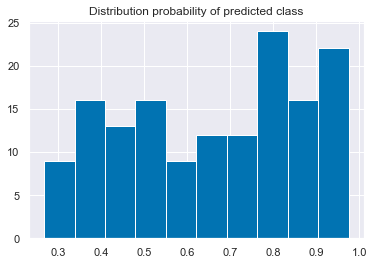

In [68]:
#Define and fit the model
model = LogisticRegression()
model = model.fit(features_train, labels_train)

#Test the model
model_prediction = model.predict_proba(features_test)
plt.hist(model_prediction.max(axis=1))
plt.title("Distribution probability of predicted class")
plt.show()

So a resonable threshold for the the predicted class is 0.8.

In [71]:
'''
Helper function that add label to a chunck dataframe and save only the row
that we can label with a certain degree of certitude (prob > treshold).
'''
def generate_label(chunk):  
        #generate vector for prediction
        vectors = TFIDF.transform(chunk['quotation'].values).toarray()
        
        #predict probability 
        model_prediction = model.predict_proba(vectors)
        
        #select only label with probability greater then 0.8
        mask =model_prediction.max(axis=1) > 0.8
        final_chunk = chunk[mask].copy()
        final_chunk['label'] = model_prediction[mask].argmax(axis=1)
        nb_nonclass = chunk.shape[0] - final_chunk.shape[0]
        
        return final_chunk.reset_index(drop=True), nb_nonclass

In [72]:
'''
Helper function to add label to the dataset of a certain year, 
and filter row that we can't classify. 
'''
def add_label(path_dataset, path_dataset_clean):
    TOT_size = 0
    TOT_size_clean = 0
    TOT_nb_nonclass = 0
    with pd.read_json(path_dataset, lines=True, compression='bz2', chunksize=100000) as df_reader:
        with bz2.open(path_dataset_clean, 'wb') as d_file:
            count = 0
            for chunk in df_reader:
                print(f'({count}) Processing chunk with {chunk.shape[0]} rows', end='\r')
                TOT_size += chunk.shape[0]
                df, nb_nonclass = generate_label(chunk.copy()) 
                
                #count number value
                TOT_nb_nonclass += nb_nonclass
                TOT_size_clean += df.shape[0]
                
                #write in the ouput file
                d_file.write(df.to_json(compression='bz2',lines=True, orient='records').encode('utf-8'))
                count+=1
    print(f'We remove {TOT_nb_nonclass} over a total of {TOT_size} ')
    print(f'The final shape of the dataset is {TOT_size_clean}')

Classification of the 2020 quotations:

In [30]:
data_folder = './data/' #TODO: put at the beggin in order to save the dataset directly in right folder.
path_dataset = data_folder + 'quotes-2020-clean.json.bz2' # path
path_dataset_clean_2020 = data_folder + 'quotes-2020-clean_classified.json.bz2' # path to cleaned dataset

In [145]:
add_label(path_dataset, path_dataset_clean) # adding of the labels 

We remove 2086989 over a total of 2118203 
The final shape of the dataset is 31214


In [32]:
# loading of the dataset 
df_2020 = pd.read_json(path_dataset_clean_2020, lines=True, compression='bz2')
df_2020.head(3)

,quotation,speaker,date,qids,urls,label
0,coupled solid institutions measured world bank...,Lim Guan Eng,2020-01-22,Q707164,themalaymailonline.com,0
1,economy free market threat socialism,Frank Pavone,2020-04-04,Q5488928,catholicnewsagency.com,0
2,probably first five games league youre kind ne...,Josh Morrissey,2020-02-05,Q13581454,winnipegfreepress.com,4


Classification of the 2019 quotations:

In [3]:
path_dataset = data_folder + 'quotes-2019-clean.json.bz2' 
path_dataset_clean_2019 = data_folder + 'quotes-2019-clean_classified.json.bz2'

In [152]:
add_label(path_dataset, path_dataset_clean) 

We remove 8512756 over a total of 8653437 
The final shape of the dataset is 140681


In [12]:
df_2019 = pd.read_json(path_dataset_clean_2019, lines=True, compression='bz2')
df_2019.head(3)

,quotation,speaker,date,qids,urls,label
0,91 old awards show young youre democrat runnin...,Jimmy Fallon,2019-02-23,Q335680,govexec.com,1
1,unique show film music heart show great perfor...,Ranveer Singh,2019-02-06,Q902879,tribune.com.pk,1
2,hatched conspiracy destabilise tdp government ...,Chandrababu Naidu,2019-03-11,Q3518013,aninews.in,2


Classification of the 2018 quotations:

In [4]:
path_dataset = data_folder + 'quotes-2018-clean.json.bz2' 
path_dataset_clean_2018 = data_folder + 'quotes-2018-clean_classified.json.bz2' 

In [159]:
add_label(path_dataset, path_dataset_clean) 

We remove 10409133 over a total of 10576739 
The final shape of the dataset is 167606


In [19]:
df_2018 = pd.read_json(path_dataset_clean_2018, lines=True, compression='bz2')
df_2018.head(3)

,quotation,speaker,date,qids,urls,label
0,adi ranveer met extensively discussed next fil...,Ranveer Singh,2018-03-13,Q902879,bollywoodhungama.com,1
1,games half lineups half,Rod Brind ` amour,2018-10-01,Q949869,wncn.com,4
2,amazon offers thousands toprated toys includin...,Sriram Parthasarathy,2018-09-30,Q7586494,hulldailymail.co.uk,4


Classification of the 2017 quotations:

In [5]:
path_dataset = data_folder + 'quotes-2017-clean.json.bz2' 
path_dataset_clean_2017 = data_folder + 'quotes-2017-clean_classified.json.bz2' 

In [166]:
add_label(path_dataset, path_dataset_clean) 

We remove 10051487 over a total of 10208628 
The final shape of the dataset is 157141


In [21]:
df_2017 = pd.read_json(path_dataset_clean_2017, lines=True, compression='bz2')
df_2017.head(3)

,quotation,speaker,date,qids,urls,label
0,labour superb saleswoman lousy product thats p...,Chris Trotter,2017-09-22,Q5108312,au.news.yahoo.com,2
1,leon bailey wanted chelsea arsenal,Leon Bailey,2017-12-26,Q20890178,dailystar.co.uk,3
2,shia labeouf character mutt williams film,David Koepp,2017-09-06,Q270178,sg.style.yahoo.com,1


Classification of the 2016 quotations:

In [6]:
path_dataset = data_folder + 'quotes-2016-clean.json.bz2' 
path_dataset_clean_2016 = data_folder + 'quotes-2016-clean_classified.json.bz2'

In [173]:
add_label(path_dataset, path_dataset_clean) 

We remove 5264348 over a total of 5348900 
The final shape of the dataset is 84552


In [22]:
df_2016 = pd.read_json(path_dataset_clean_2016, lines=True, compression='bz2')
df_2016.head(3)

,quotation,speaker,date,qids,urls,label
0,mmigration continues good economy,Hillary Clinton,2016-07-12,Q6294,breitbart.com,0
1,aurangzeb dynamic film treat work amazing cast...,Arjun Kapoor,2016-05-11,Q2383191,india.com,1
2,carlos good manager nice guy work,Glenn Loovens,2016-04-19,Q27735,thestar.co.uk,3


Classification of the 2015 quotations:

In [7]:
path_dataset = data_folder + 'quotes-2015-clean.json.bz2' 
path_dataset_clean_2015 = data_folder + 'quotes-2015-clean_classified.json.bz2'

In [180]:
add_label(path_dataset, path_dataset_clean) 

We remove 8096224 over a total of 8235740 
The final shape of the dataset is 139516


In [23]:
df_2015 = pd.read_json(path_dataset_clean_2015, lines=True, compression='bz2')
df_2015.head(3)

,quotation,speaker,date,qids,urls,label
0,also one males maledominated film one heroes film,Taapsee Pannu,2015-01-16,Q7672815,glamsham.com,1
1,felt good tonight seeing puck well guys chippi...,Cam Johnson,2015-12-12,Q3651108,grandforksherald.com,4
2,anything cup tasty,RICHARD CHAPLOW,2015-08-25,Q2081399,yorkshirepost.co.uk,3


### Proportion of topics <a class="anchor" id="section_4_2"></a>

In [156]:
'''
Helper function that plots the distribution of the column x of the dataframe.
'''
def plot_distrib(df1, df2, df3, df4, df5, df6, x) : 
    #create the subplots 
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,15))
    fig.tight_layout(pad=5.0)
    # plot the distributions of the column x of the dataframe 
    sns.histplot(df1, x = x, binwidth= None, stat = 'density', discrete = True, ax=axes[0,0]).set_title('2015')
    sns.histplot(df2, x = x, binwidth= None, stat = 'density', discrete = True, ax=axes[0,1]).set_title('2016')
    sns.histplot(df3, x = x, binwidth= None, stat = 'density', discrete = True, ax=axes[0,2]).set_title('2017')
    sns.histplot(df4, x = x, binwidth= None, stat = 'density', discrete = True, ax=axes[1,0]).set_title('2018')
    sns.histplot(df5, x = x, binwidth= None, stat = 'density', discrete = True, ax=axes[1,1]).set_title('2019')
    sns.histplot(df6, x = x, binwidth= None, stat = 'density', discrete = True, ax=axes[1,2]).set_title('2020')
    fig.suptitle(f'distribution of {x}')
    plt.xticks(rotation=45)
    plt.show()

In [180]:
'''
Helper function that plots the pie chart for the column x of the dataframe 'data'.
'''
def plot_pie(data,x, label, year) : 
    labels = label
    # group the data for the column x and count the values  
    data = data.groupby(x)[x].value_counts() 
    # plot the pie chart 
    data.plot.pie(autopct="%.1f%%", labels = labels, labeldistance=1.5, pctdistance=1.2, radius = 2)
    plt.title(f'Proportion of each {x} for year {year}', pad=70 )
    plt.show()

Let's visualize the density distribution of topics for each year : 

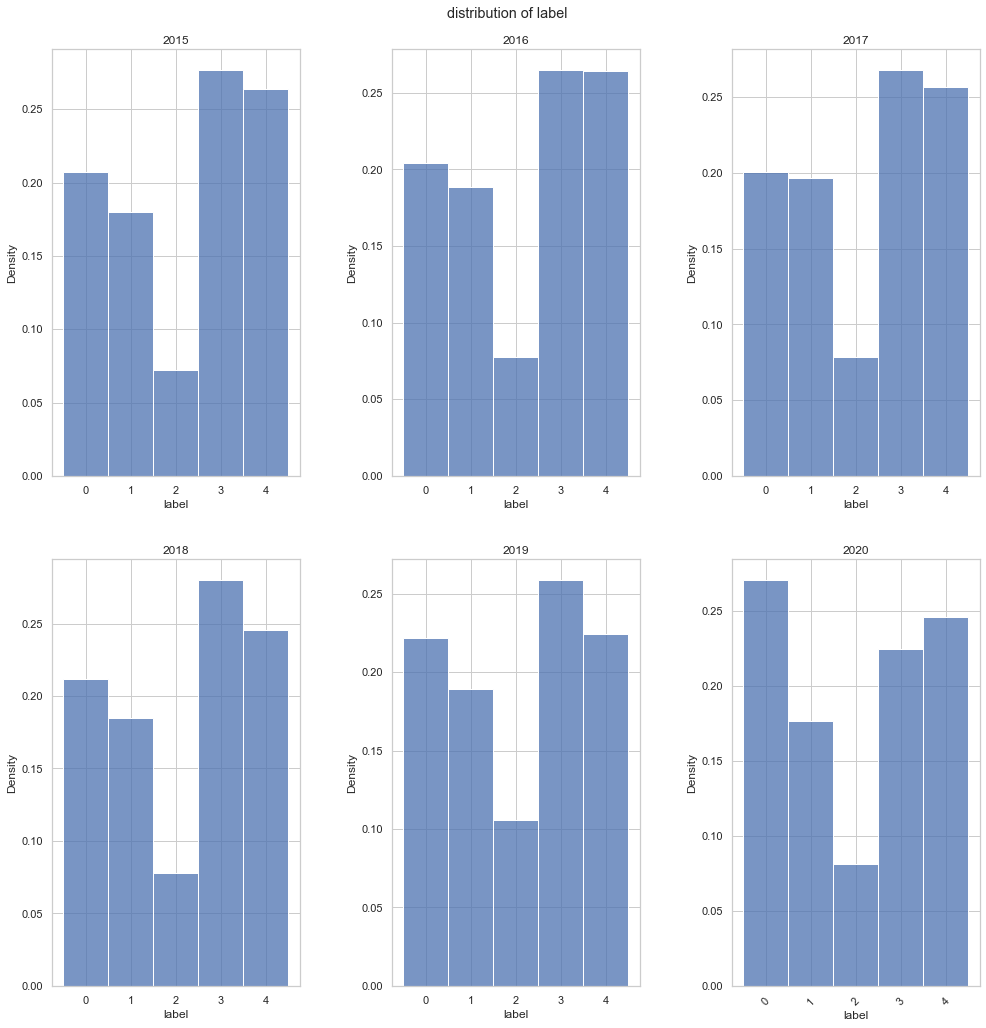

In [158]:
plot_distrib(df_2015, df_2016,df_2017, df_2018, df_2019, df_2020, 'label')

Here, we notice that the distribution of topics amoung the years are quite similar. Indeed, for every year, the most talked about topic is sport and the less talked about is politics. As the distribition of topics is similar for each year, the analysis of the type of speakers amoung the years will be representative as the labels have a comparable number of data. 

Let's visualize the distributionas pie charts for each year : 

In [162]:
CLASS = ['business', 'entertainment', 'politics', 'sport', 'tech'] #labels of the topics

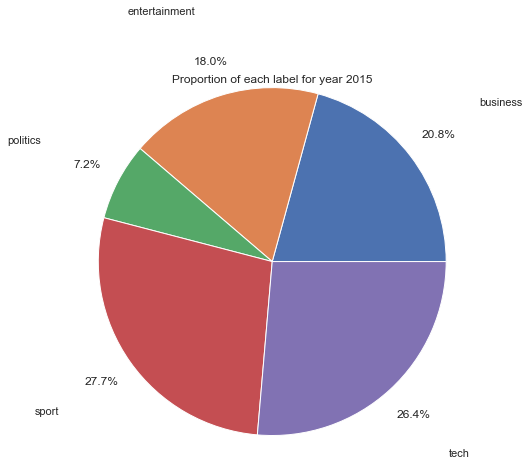

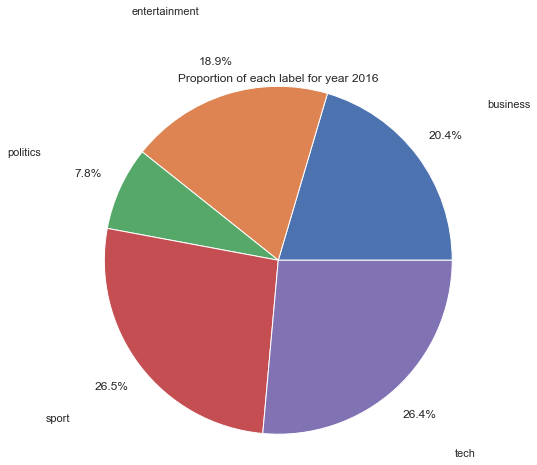

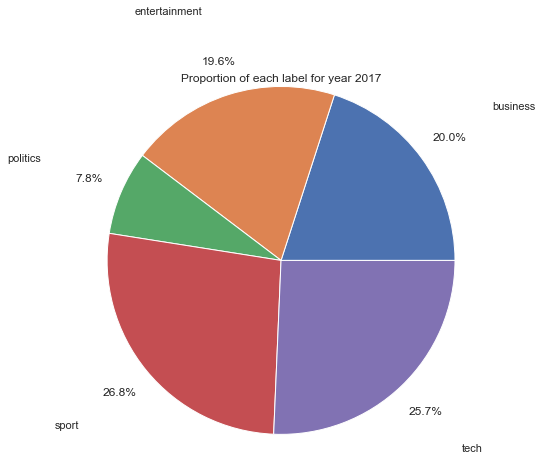

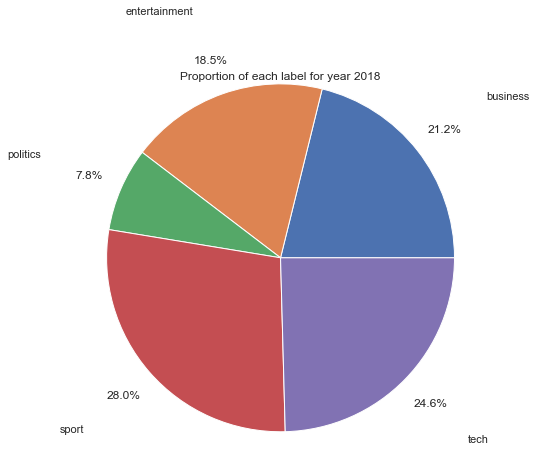

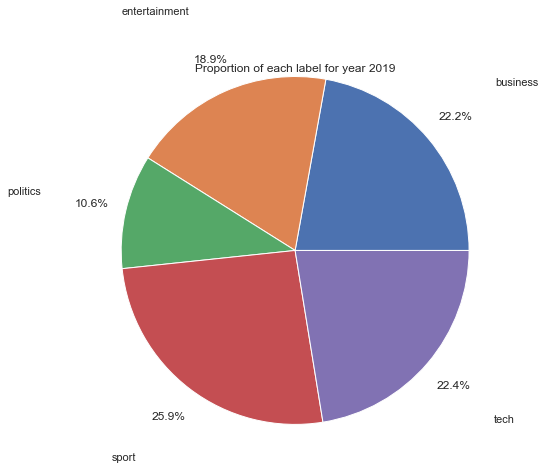

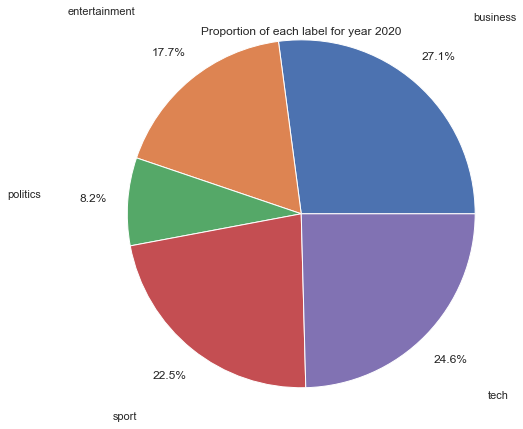

In [182]:
# plot of the pie chart for every year, for good visulalisation we choose to plot individually for each dataset 
plot_pie(df_2015, 'label', CLASS, 2015)
plot_pie(df_2016, 'label', CLASS, 2016)
plot_pie(df_2017, 'label', CLASS, 2017)
plot_pie(df_2018, 'label', CLASS, 2018)
plot_pie(df_2019, 'label', CLASS, 2019)
plot_pie(df_2020, 'label', CLASS, 2020)

The same observation can be made as before. Indeed, we also deduce that the proportion of each label is similar for every datasets from 2015 to 2020. 

### Time evolution of topics <a class="anchor" id="section_4_3"></a>

In [166]:
'''
Helper function that plots the evolution of the column x in the dataframe in function of time 
'''
def evolution_in_time(df1,df2,df3,df4,df5,df6, x) : 
    # define the size of the plot 
    fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(15,45))
    # group the data frame by date, count the corresponding values for the column x and plot 
    df1.groupby(['date'])[x].value_counts().unstack().plot(ax=ax[0])
    df2.groupby(['date'])[x].value_counts().unstack().plot(ax=ax[1])
    df3.groupby(['date'])[x].value_counts().unstack().plot(ax=ax[2])
    df4.groupby(['date'])[x].value_counts().unstack().plot(ax=ax[3])
    df5.groupby(['date'])[x].value_counts().unstack().plot(ax=ax[4])
    df6.groupby(['date'])[x].value_counts().unstack().plot(ax=ax[5])
    plt.ylabel('count')
    plt.suptitle('evolution of labels in function of time for all the years')
    plt.show()



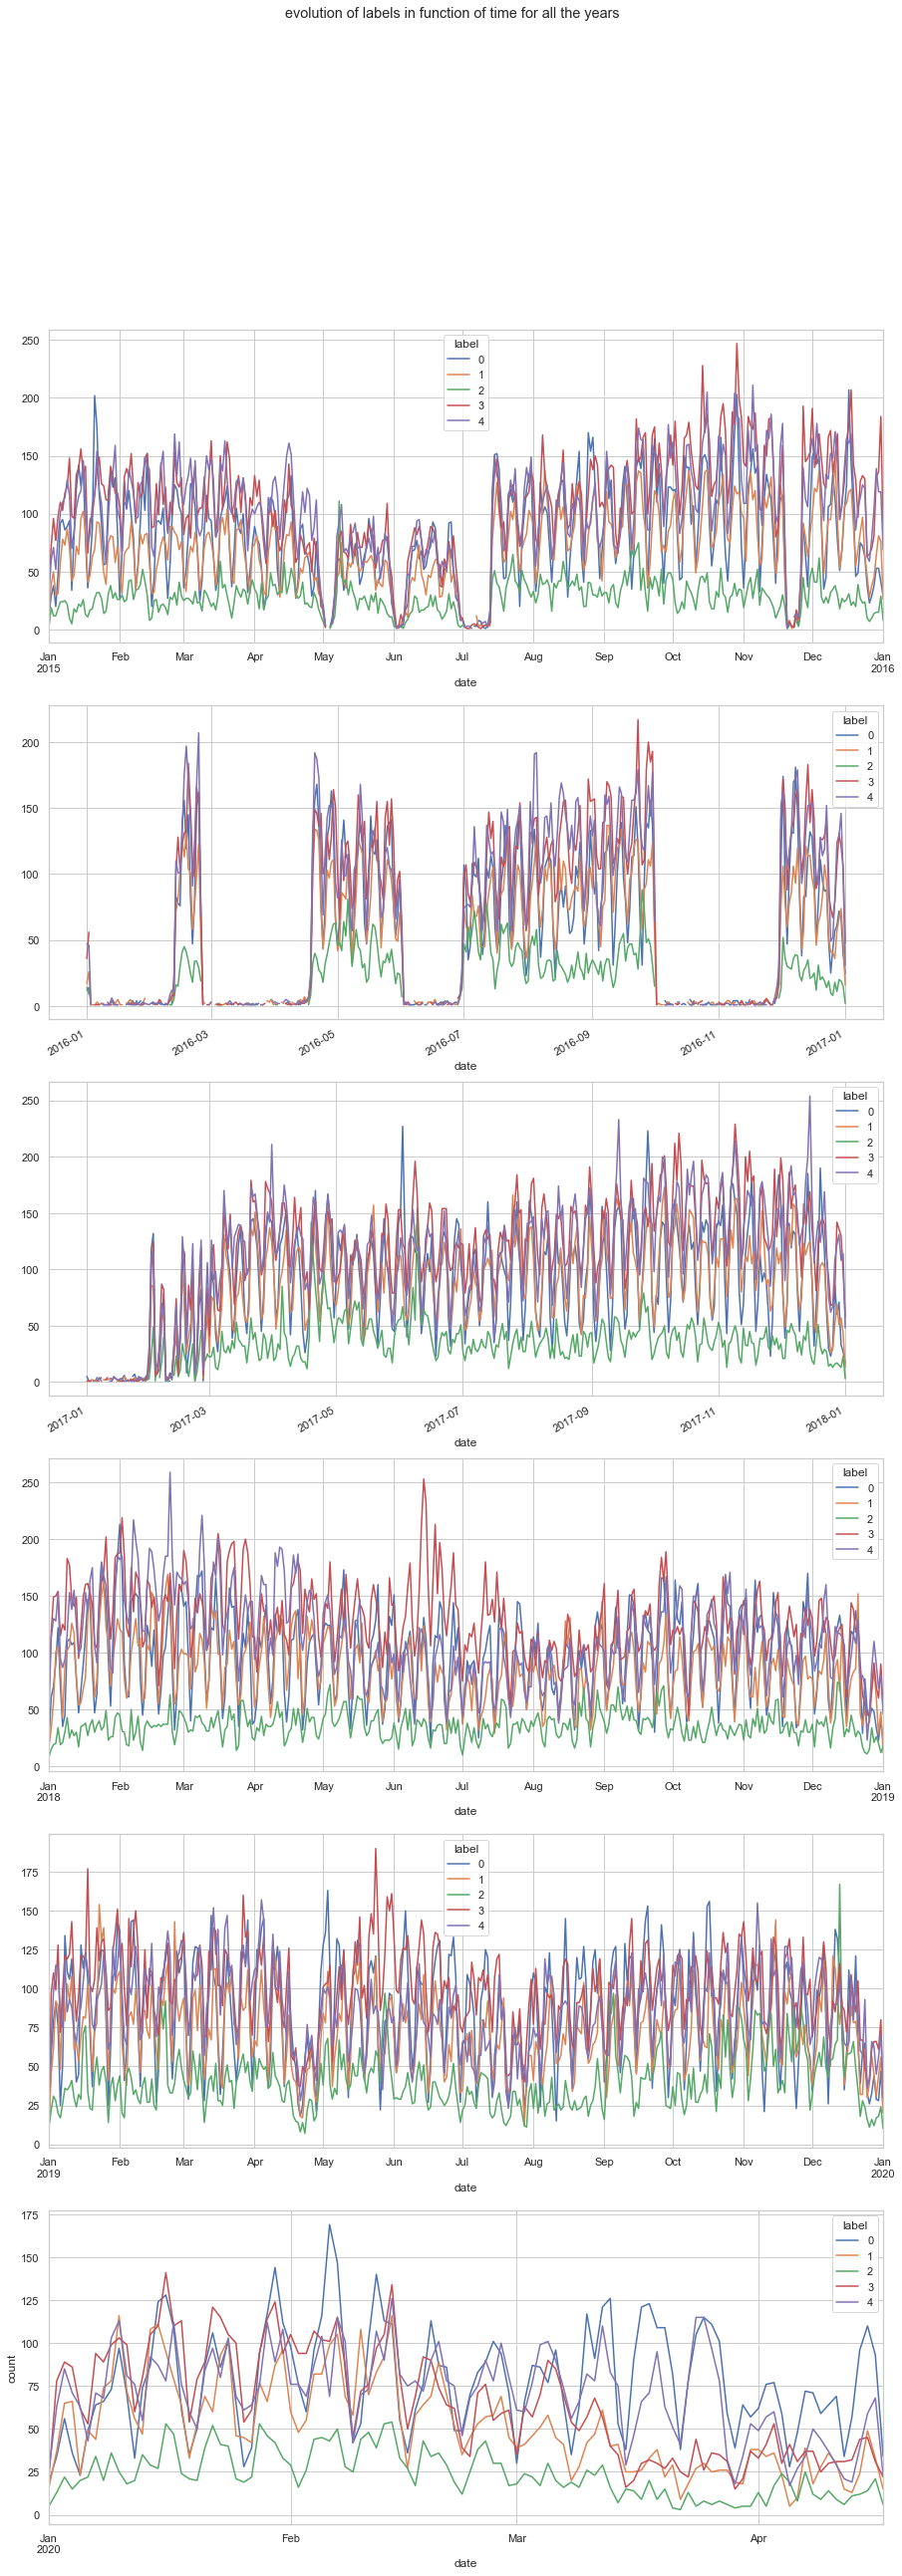

In [167]:
evolution_in_time(df_2015, df_2016,df_2017, df_2018, df_2019, df_2020, 'label')

For all topics, the evolution in times of number of quotations is mainly oscillatory with the same phase and period (but not the same amplitude). Therefore, there is no distinct evolution trend in time across topics.

### Conclusion for further analysis <a class="anchor" id="section_4_4"></a>

In [146]:
'''
Helper function that compute the proportion of duplicated speakers and 
the proportion of duplicated speakers assiciated with different topics
'''
def analyses_of_multiple_subject_speakers(df, x) : 
    
    # total number of different speakers
    num_tot_speakers = df.drop_duplicates(subset=['speaker'], keep = 'first').shape[0]
    
    # count number of mutiple quoted speakers
    d_speakers = df[df.duplicated(['speaker'], keep=False)]
    num_mult_speakers = d_speakers.drop_duplicates(subset=['speaker'], keep = 'first').shape[0]

    # group the resulting dataframe by speakers and count the corresponding x values
    d_count = d_speakers.groupby(['speaker'])[x].mean()
    # get the number of duplicated speakers that have the same topic for each quotes : 
    count = 0 
    for n in d_count : 
        if n ==1 or n ==2 or n == 3 or n == 4 : 
            count = count + 1
        
    # number or duplicated speaker that talks about different topics 
    diff_topics = num_mult_speakers - count
    
    # display proportions of multiple speakers and propotion of mutilple speakers quoted for different topic on entire dataset 
    print(f'the proportion of speakers quoted more than once on the entire dataset is : {num_mult_speakers/num_tot_speakers}.')
    print(f'the proportion of speakers quoted more than once on different subject on the entire dataset is : {diff_topics/num_tot_speakers}.')
   

In [147]:
analyses_of_multiple_subject_speakers (df_2020, 'label') 

the proportion of speakers quoted more than once on the entire dataset is : 0.35017617512557164.
the proportion of speakers quoted more than once on different subject on the entire dataset is : 0.16980283379563685.


In [148]:
analyses_of_multiple_subject_speakers (df_2019, 'label')

the proportion of speakers quoted more than once on the entire dataset is : 0.4418319362093641.
the proportion of speakers quoted more than once on different subject on the entire dataset is : 0.23170108362298097.


In [149]:
analyses_of_multiple_subject_speakers(df_2018, 'label')

the proportion of speakers quoted more than once on the entire dataset is : 0.447324735027455.
the proportion of speakers quoted more than once on different subject on the entire dataset is : 0.23513386966330396.


In [150]:
analyses_of_multiple_subject_speakers(df_2017, 'label')

the proportion of speakers quoted more than once on the entire dataset is : 0.4453627979815556.
the proportion of speakers quoted more than once on different subject on the entire dataset is : 0.2304245693405255.


In [151]:
analyses_of_multiple_subject_speakers(df_2016, 'label')

the proportion of speakers quoted more than once on the entire dataset is : 0.39477662346016534.
the proportion of speakers quoted more than once on different subject on the entire dataset is : 0.19738831173008267.


In [152]:
analyses_of_multiple_subject_speakers(df_2015, 'label')

the proportion of speakers quoted more than once on the entire dataset is : 0.4324121075390111.
the proportion of speakers quoted more than once on different subject on the entire dataset is : 0.22638183869148337.


There is a mean of 21.2% of the speakers in all the Datasets that are quoted more and talking about different subjects (buisness, entertainment, politics, sport or technology). Therefore, our futher analysis to classify the main represented type of speaker across topics will possibly be based on some similar speakers across different group of topics. However, the majority of the speakers are quoted only once (only 41.75% in mean across all datasets are quoted more than once), this result shows that our classification according to the type of speakers can indeed be performed on this dataset and will be possibly different across topics. Further analysis regarding age, nationality and gender of the speakers will be representative across topics.

## Categorization of the speakers  <a class="anchor" id="chapter5"></a>

In [168]:
'''
Helper function that is used to merge quotebank dataset and speaker attributs according to same QID number
'''
def merged_datasets (data1, data2) : 
    return pd.merge(data1, data2 ,how='inner' ,left_on=['qids'],right_on=['id'])

In [169]:
#load speaker_attributes
path = data_folder + "speaker_attributes_final.json.bz2"
speaker_atr = pd.read_json(path, lines=True, compression='bz2')
speaker_atr.head(3)

,date_of_birth,nationality,gender,id
0,1732,Great Britain,male,Q23
1,1952,United Kingdom,male,Q42
2,1868,Belgium,male,Q1868


We have a dataframe with the characteristics for each speaker. Now, for the datasets of every year, we merge the informations of the speakers according to their corresponding QID number : 

In [170]:
df_2020_merge = merged_datasets(df_2020,speaker_atr )
df_2020_merge.head(3)

,quotation,speaker,date,qids,urls,label,date_of_birth,nationality,gender,id
0,coupled solid institutions measured world bank...,Lim Guan Eng,2020-01-22,Q707164,themalaymailonline.com,0,1960,Malaysia,male,Q707164
1,impact lower tourist arrivals local economy un...,Lim Guan Eng,2020-01-31,Q707164,theedgemarkets.com,0,1960,Malaysia,male,Q707164
2,supported governments proposed initiatives pro...,Lim Guan Eng,2020-01-06,Q707164,theedgemarkets.com,0,1960,Malaysia,male,Q707164


In [171]:
df_2019_merge = merged_datasets(df_2019,speaker_atr )
df_2019_merge.head(3)

,quotation,speaker,date,qids,urls,label,date_of_birth,nationality,gender,id
0,91 old awards show young youre democrat runnin...,Jimmy Fallon,2019-02-23,Q335680,govexec.com,1,1974,United States of America,male,Q335680
1,weird testament think marvel film know antman ...,Jimmy Fallon,2019-11-21,Q335680,complex.com,1,1974,United States of America,male,Q335680
2,know whats funny saw picture holding coffee cup,Jimmy Fallon,2019-05-11,Q335680,toofab.com,3,1974,United States of America,male,Q335680


In [172]:
df_2018_merge = merged_datasets(df_2018,speaker_atr )
df_2018_merge.head(3)

,quotation,speaker,date,qids,urls,label,date_of_birth,nationality,gender,id
0,adi ranveer met extensively discussed next fil...,Ranveer Singh,2018-03-13,Q902879,bollywoodhungama.com,1,1985,India,male,Q902879
1,time way mounting film everything pumping beco...,Ranveer Singh,2018-08-06,Q902879,gulfnews.com,1,1985,India,male,Q902879
2,gully boy perhaps dearest film one closest ban...,Ranveer Singh,2018-02-11,Q902879,indianexpress.com,1,1985,India,male,Q902879


In [173]:
df_2017_merge = merged_datasets(df_2017,speaker_atr )
df_2017_merge.head(3)

,quotation,speaker,date,qids,urls,label,date_of_birth,nationality,gender,id
0,labour superb saleswoman lousy product thats p...,Chris Trotter,2017-09-22,Q5108312,au.news.yahoo.com,2,1956,New Zealand,male,Q5108312
1,dont quick condemn labour greens cautioning su...,Chris Trotter,2017-03-27,Q5108312,m.nzherald.co.nz,2,1956,New Zealand,male,Q5108312
2,think beginning jacinda effect lift labour clo...,Chris Trotter,2017-08-10,Q5108312,newstalkzb.co.nz,2,1956,New Zealand,male,Q5108312


In [174]:
df_2016_merge = merged_datasets(df_2016,speaker_atr )
df_2016_merge.head(3)

,quotation,speaker,date,qids,urls,label,date_of_birth,nationality,gender,id
0,mmigration continues good economy,Hillary Clinton,2016-07-12,Q6294,breitbart.com,0,1947,United States of America,female,Q6294
1,many wedded failed theory trickledown economic...,Hillary Clinton,2016-07-29,Q6294,vox.com,0,1947,United States of America,female,Q6294
2,answer rant rave cut world would end killing e...,Hillary Clinton,2016-08-13,Q6294,delmarvapublicradio.net,0,1947,United States of America,female,Q6294


In [176]:
df_2015_merge = merged_datasets(df_2015,speaker_atr )
df_2015_merge.head(3)

,quotation,speaker,date,qids,urls,label,date_of_birth,nationality,gender,id
0,also one males maledominated film one heroes film,Taapsee Pannu,2015-01-16,Q7672815,glamsham.com,1,1987,India,female,Q7672815
1,sobbing scenes film made celebrate relationshi...,Taapsee Pannu,2015-11-05,Q7672815,canindia.com,1,1987,India,female,Q7672815
2,67 moment film catches connections relatives a...,Taapsee Pannu,2015-11-01,Q7672815,canindia.com,1,1987,India,female,Q7672815


The datasets are ready to perform analysis of the type of speakers according to topics. 
First of all, we can analyse the age of the speakers. 

### Age Analysis <a class="anchor" id="section_5_1"></a>

#### Overall age distribution <a class="anchor" id="section_5_1_1"></a>

In [178]:
'''
Helper function that computes the number and the fraction of speakers with date of birth smaller than given date
'''
def count_date_of_birth_smaller(df, date_of_birth_value):
    count_value = df.query(f'date_of_birth < {date_of_birth_value}').date_of_birth.count()
    perc_value = round(count_value / len(df) * 100, 2)             
    print(f'Number of speakers with date of birth earlier than {date_of_birth_value} is {count_value}, which is {perc_value}% of the dataset')

In [179]:
count_date_of_birth_smaller(df_2020_merge, 1900)
count_date_of_birth_smaller(df_2019_merge, 1900)
count_date_of_birth_smaller(df_2018_merge, 1900)
count_date_of_birth_smaller(df_2017_merge, 1900)
count_date_of_birth_smaller(df_2016_merge, 1900)

Number of speakers with date of birth earlier than 1900 is 6, which is 0.02% of the dataset
Number of speakers with date of birth earlier than 1900 is 29, which is 0.02% of the dataset
Number of speakers with date of birth earlier than 1900 is 67, which is 0.04% of the dataset
Number of speakers with date of birth earlier than 1900 is 53, which is 0.03% of the dataset
Number of speakers with date of birth earlier than 1900 is 58, which is 0.04% of the dataset


In [190]:
'''
Helper function that plots the distribution of speakers' date of birth
'''
def plot_distrib_date_of_birth (data) : 
    sns.displot(data, x = 'date_of_birth',stat = 'density')
    plt.xlim(1900,2020)
    plt.title('distribution of the date of birth of speakers')
    plt.show()

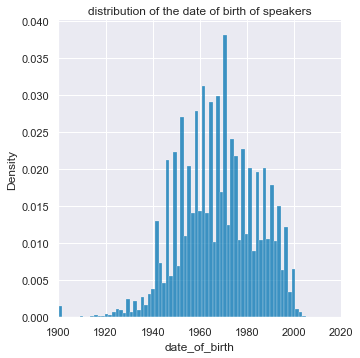

In [191]:
plot_distrib_date_of_birth(df_2020_merge)

In [192]:
mean_date_of_birth_evolution = []
date = []

In [193]:
'''
Helper function that returns statistical descriptions of date of birth of speakers for one year
'''
def statistic_date_of_birth_description (data, coress_date) :
    mean_date_of_birth_evolution.append(data['date_of_birth'].mean())
    date.append(coress_date)
    return data['date_of_birth'].describe()

In [194]:
statistic_date_of_birth_description(df_2020_merge, 2020)

count    31214.000000
mean      1967.935862
std         16.588317
min       1813.000000
25%       1956.000000
50%       1968.000000
75%       1980.000000
max       2005.000000
Name: date_of_birth, dtype: float64

In [195]:
df_2020_merge['date_of_birth_category'] = pd.cut(df_2020_merge['date_of_birth'],[0,1900,1920,1940,1960,1980,2000,2020])

In [196]:
df_2020_merge['date_of_birth_category'].value_counts()

(1960, 1980]    12931
(1940, 1960]     9306
(1980, 2000]     7691
(1920, 1940]     1051
(1900, 1920]      132
(2000, 2020]       97
(0, 1900]           6
Name: date_of_birth_category, dtype: int64

In [197]:
'''
Helper function that plots number of speakers per category of date of birth
'''
def dist_count_date_of_birth_category(data): 
    count_date_of_birth_category = data.groupby('date_of_birth_category')['label'].count()
    count_date_of_birth_category = pd.DataFrame(count_date_of_birth_category)
    count_date_of_birth_category.plot.bar()
    plt.yscale('log')
    plt.ylabel('Number of speakers per category of date of birth')
    plt.title('Histogram of number of speakers per category of date of birth')

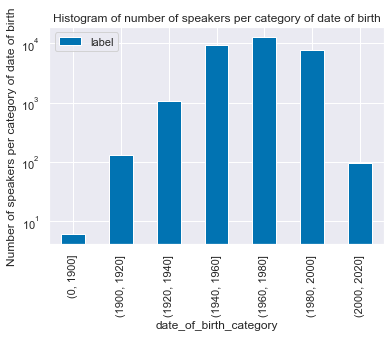

In [198]:
dist_count_date_of_birth_category(df_2020_merge)

#### Age distribution per topics <a class="anchor" id="section_5_1_2"></a>

In [199]:
'''
Helper function that plots mean date of birth according to topics
'''
def dist_mean_date_of_birth_topic (data): 
    mean_date_of_birth_per_topic = data.groupby('label')['date_of_birth'].mean()
    mean_date_of_birth_per_topic = pd.DataFrame(mean_date_of_birth_per_topic)
    mean_date_of_birth_per_topic.plot.bar()
    plt.ylabel('mean date of birth')
    plt.title('Histogram of mean date of birth per topic')

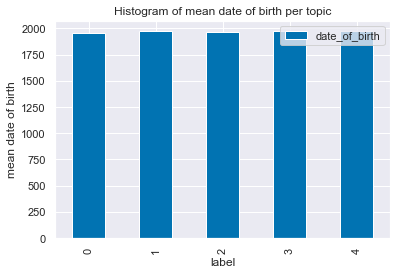

In [200]:
dist_mean_date_of_birth_topic(df_2020_merge)

#### Time evolution of mean age of speakers <a class="anchor" id="section_5_1_3"></a>

In [201]:
''' TO VERIFY 
Helper function that plots the evolution of mean age of speakers across years
'''
def evolution_date_of_birth_age(mean, date) : 
    plt.plot(date, mean_date_of_birth)
    plt.title('evolution over all topics of mean age in function of year')

### Gender Analysis <a class="anchor" id="section_5_2"></a>

#### Gender distribution per topic <a class="anchor" id="section_5_2_1"></a>

In [202]:
#for analysis, we can look at the values of gender of speakers and their number
df_2020_merge['gender'].value_counts()

male                  25918
female                 5255
genderfluid              12
transgender female        8
non-binary                8
cisgender male            6
transgender male          3
cisgender female          3
shemale                   1
Name: gender, dtype: int64

In [203]:
''' 
Helper function that plots the distribution of gender per topics
'''
def hist_feature_per_topics (data, feature) : 
    data[feature].hist(by=data['label'], figsize=(15,15), bins =20 , log = True, xrot = 45)
    plt.suptitle(f'Histograms of {feature} per topics')
    plt.show()

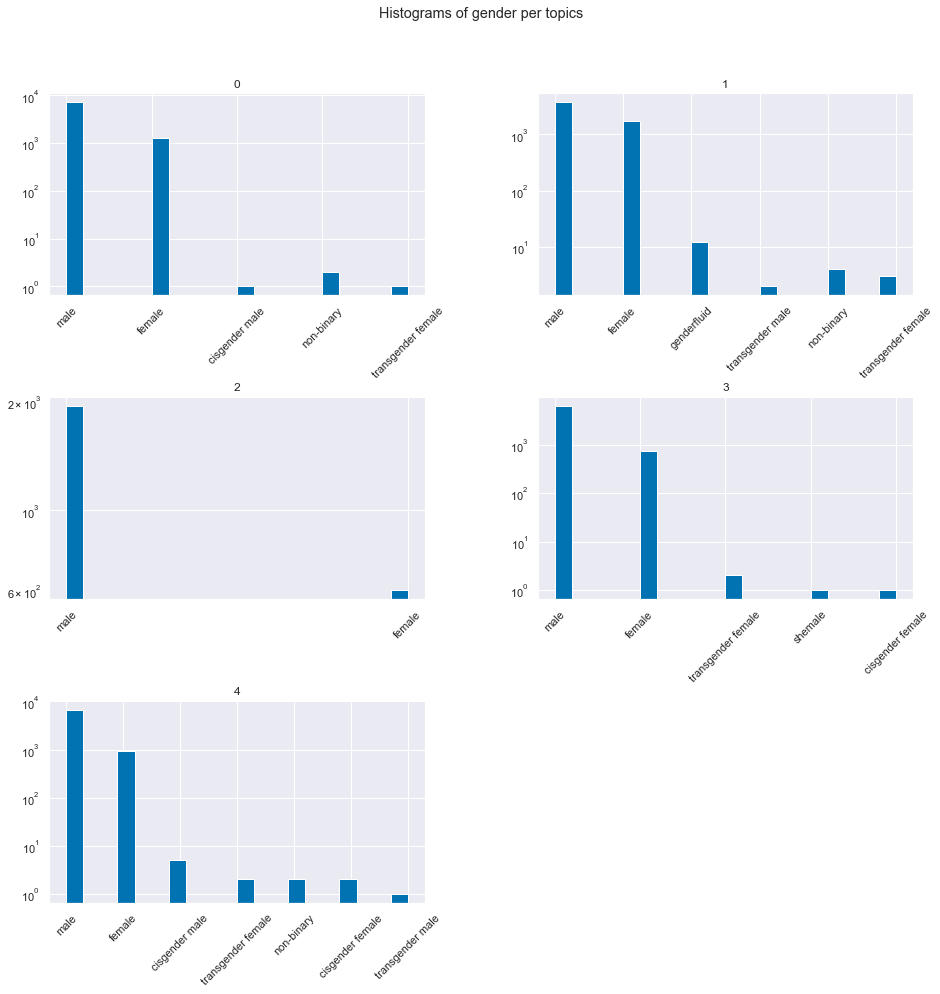

In [205]:
hist_feature_per_topics(df_2020_merge, 'gender')

#### Time evolution of gender representation <a class="anchor" id="section_5_2_3"></a>

### Representation of age and gender across news sources <a class="anchor" id="section_5_3"></a>

In [206]:
'''
Helper function that plots the gender repartition in function of date of birth for a specific news source and a specific topic
'''
def describe_date_of_birth_and_gender(site, label, data):
    data = data[data.urls == site] 
    data = data[data.label == label]
    data.gender = pd.Categorical(data.gender)
    data['gender_code'] = data.gender.cat.codes
    print("Value Count: ")
    print(data[['gender','gender_code' ]].value_counts())
    plt.figure(figsize=(20, 10))
    plt.plot(data.date_of_birth, data['gender_code'], 'o')
    plt.xlabel('date_of_birth')
    plt.ylabel('gender')
    plt.title(f'distribution of gender repartition in function of date of birth of {label} topic and {site} press source')
    plt.show()

Value Count: 
gender  gender_code
male    1              60
female  0              11
dtype: int64


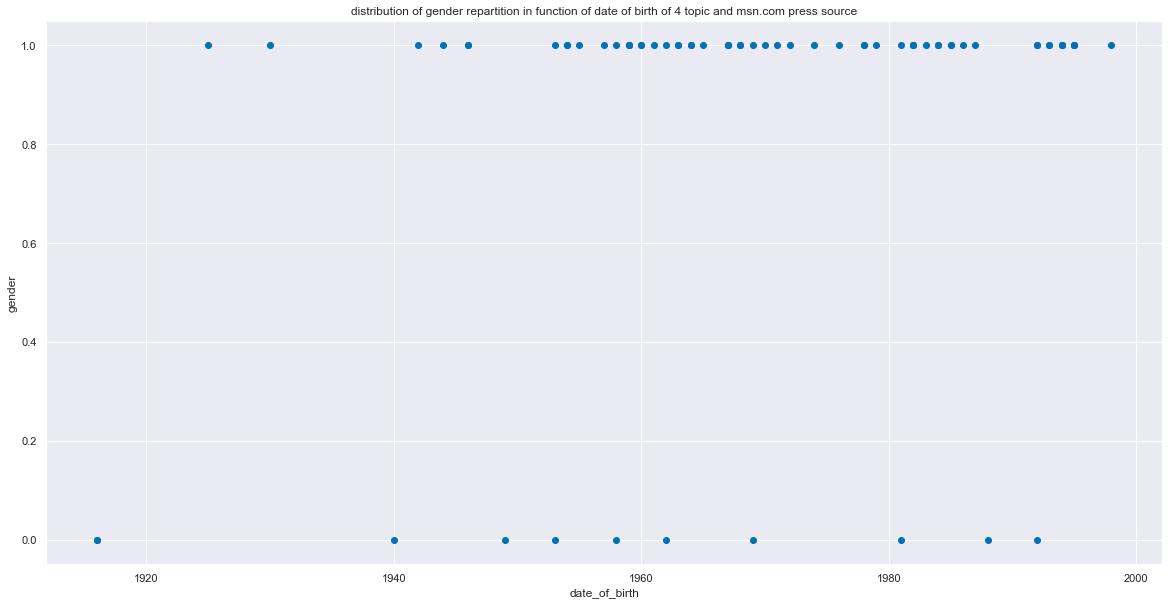

In [208]:
describe_date_of_birth_and_gender('msn.com', 4, df_2020_merge)

### Nationality Analysis <a class="anchor" id="section_5_4"></a>

#### Overall nationality distribution <a class="anchor" id="section_5_4_1"></a>

In [209]:
df_2020_merge['nationality'].describe()

count                        31214
unique                         187
top       United States of America
freq                         12211
Name: nationality, dtype: object

In [211]:
n=5
names = df_2020_merge['nationality'].value_counts()[:n].index.tolist()
data_plot = df_2020_merge.loc[df_2020_merge['nationality'].isin(names)]

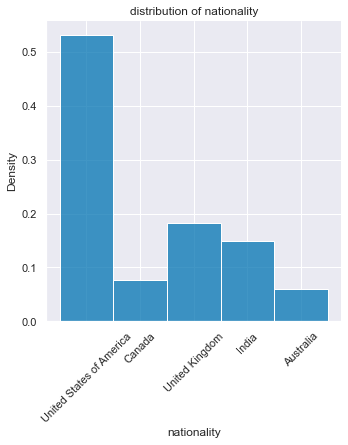

In [212]:
plot_distrib(data_plot, 'nationality')

#### Nationality distribution per topics <a class="anchor" id="section_5_4_2"></a>

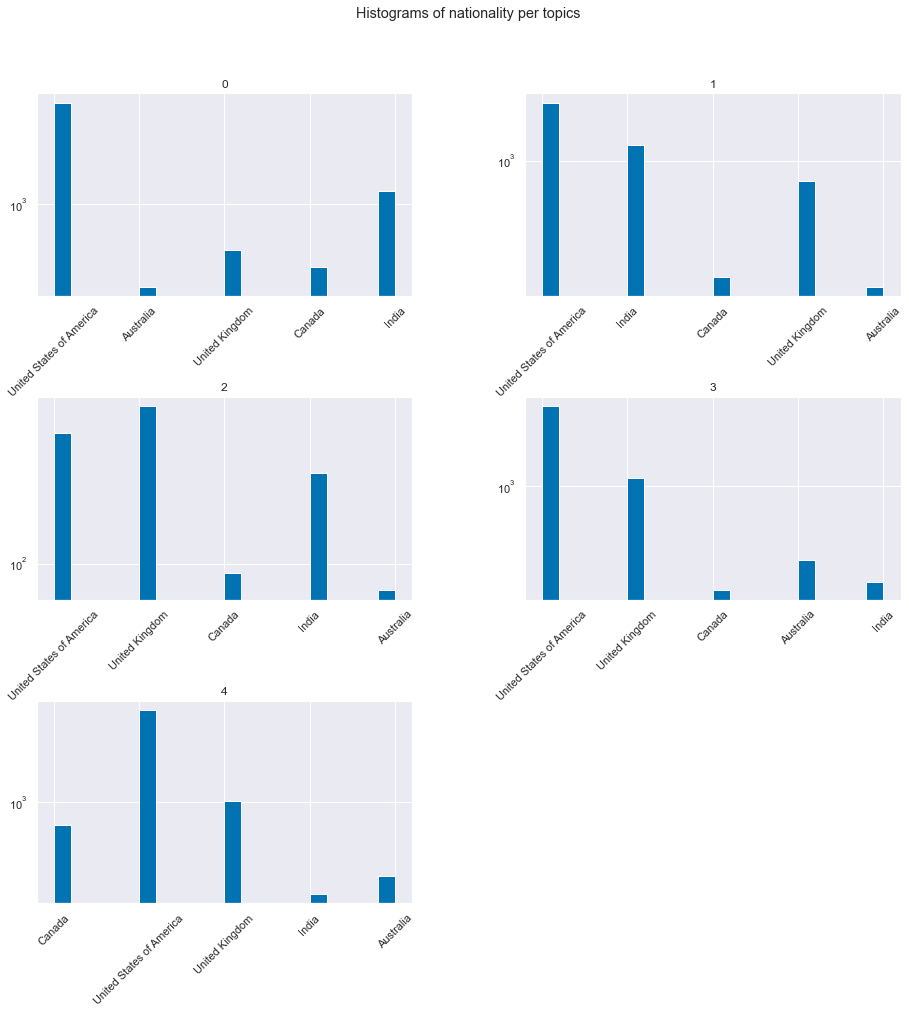

In [213]:
hist_feature_per_topics(data_plot, 'nationality')

#### Evolution of nationality representation over time <a class="anchor" id="section_5_4_3"></a>

#### Link between nationality and and date of birth representation <a class="anchor" id="section_5_4_4"></a>

In [214]:
'''
Helper function that plots mean date of birth according to nationality
'''
def dist_mean_date_of_birth_nationality(data): 
    mean_date_of_birth_per_nationality = data.groupby('nationality')['date_of_birth'].mean()
    mean_date_of_birth_per_nationality = pd.DataFrame(mean_date_of_birth_per_nationality)
    mean_date_of_birth_per_nationality.plot.bar()
    plt.yscale('log')
    plt.ylabel('mean date of birth')
    plt.title('Histogram of mean date of birth per nationality')

In [219]:
#for analysis we can look at 20 the most quoted nationalities
df_2020_merge['nationality'].value_counts()[:20]

United States of America      12211
United Kingdom                 4213
India                          3416
Canada                         1755
Australia                      1394
Germany                         736
South Africa                    556
Ireland                         523
France                          477
New Zealand                     475
Spain                           418
Nigeria                         392
Italy                           273
Japan                           264
Malaysia                        221
Israel                          194
Philippines                     181
Kingdom of the Netherlands      166
Pakistan                        153
South Korea                     151
Name: nationality, dtype: int64

In [220]:
names = df_2020_merge['nationality'].value_counts()[:20].index.tolist()
df_plot = df_2020_merge.loc[df_2020_merge['nationality'].isin(names)]

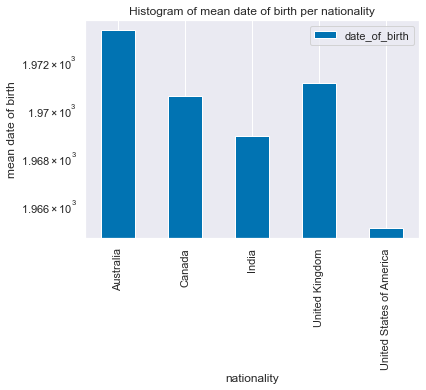

In [221]:
# plot mean date of birth for 20 the most quoted nationalities
dist_mean_date_of_birth_nationality(data_plot)

#### link between nationality and gender representation <a class="anchor" id="section_5_4_5"></a>

In [222]:
'''
Helper function that plots the gender repartition in function of nationality
'''
def describe_nationality_and_gender(data):
    data.gender = pd.Categorical(data.gender)
    data['gender_code'] = data.gender.cat.codes
    print("Value Count: ")
    print(data[['gender','gender_code' ]].value_counts())
    plt.figure(figsize=(20, 10))
    plt.plot(data.nationality, data['gender_code'], 'o')
    plt.xticks(rotation = 45)
    plt.xlabel('nationality')
    plt.ylabel('gender')
    plt.title(f'distribution of gender repartition in function of nationality')
    plt.show()

/Users/filipposalmina/.conda/envs/ada/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/var/folders/73/9b5bcd4138vbrx0mqs3mv2y40000gn/T/ipykernel_41741/2968261512.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gender_code'] = data.gender.cat.codes


Value Count: 
gender              gender_code
male                3              18762
female              1               4195
genderfluid         2                 12
non-binary          4                  8
transgender female  6                  7
transgender male    7                  3
cisgender female    0                  1
shemale             5                  1
dtype: int64


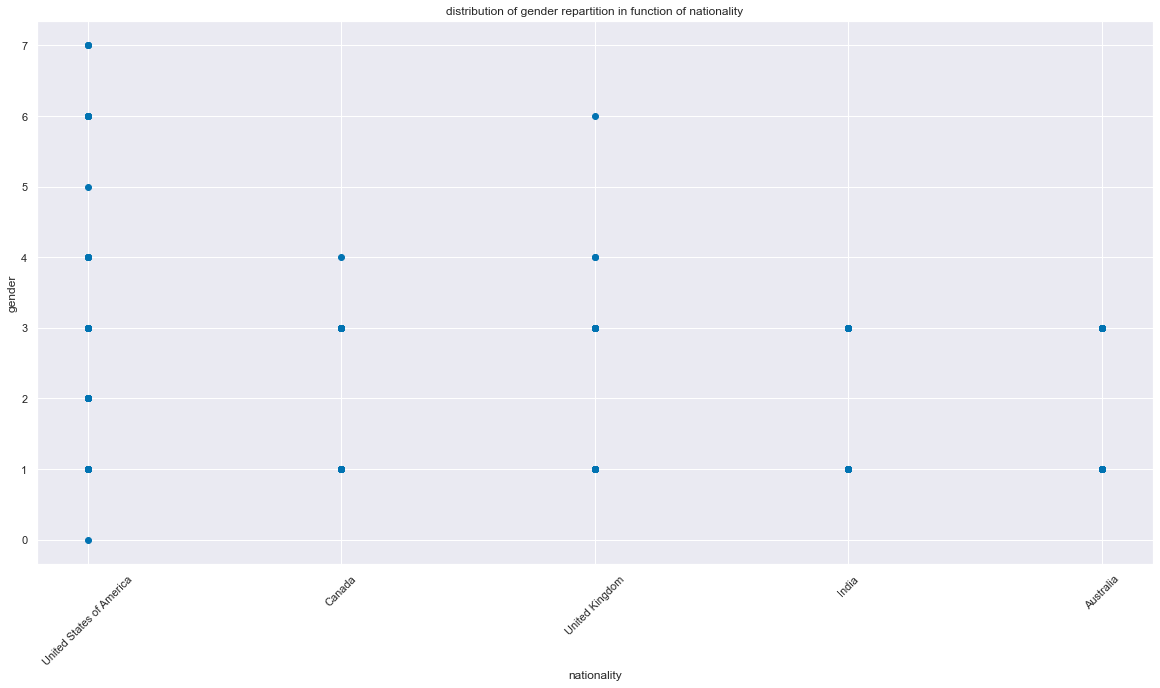

In [223]:
describe_nationality_and_gender(data_plot)

## Final Conclusion  <a class="anchor" id="chapter6"></a>

Those different analysis will be done in order to asses if we can find a significant overall evolution of different types of speakers quoted the last 6 years in the worldwide press.